## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as scheduler
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset, Dataset
from torchvision.datasets import DatasetFolder

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.ColorJitter((0.875, 1.125), (0.5, 1.5), (0.5, 1.5), (-0.05, 0.05)),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Training


In [4]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


In [5]:
def get_pseudo_labels(dataset, model, threshold):
    # This functions generates pseudo-label of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    index = []
    label = []

    for i, batch in enumerate(tqdm(dataloader)):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                index.append(i * batch_size + j)
                label.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    model.train()
    return PseudoDataset(Subset(dataset, index), label)


In [6]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [7]:
def train_model(model, do_semi, cfg, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.
    best_loss = 100.
    best_epoch = 0
    best_model = None

    for epoch in range(cfg["n_epochs"]):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, cfg["pseudo_th"])

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=cfg["batch_size"], shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(cfg["device"]))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(cfg["device"]))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(cfg["device"])).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(cfg["device"]))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(cfg["device"]))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(cfg["device"])).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Update the scheduler.
        if do_semi and epoch >= 25:
            scheduler.step(valid_acc)

        # Save the loss and accuracy for each epoch.
        history["train_loss"].append(train_loss)
        history["val_loss"].append(valid_loss)
        history["train_acc"].append(train_acc.cpu())
        history["val_acc"].append(valid_acc.cpu())

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") >= float(f"{best_acc:.5f}") and round(valid_loss, 5) < round(best_loss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{best_epoch + 1}_{best_acc}.pth")
            best_acc = valid_acc
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        # Print the information.
        print(f"[Train | {epoch + 1:03d}/{cfg['n_epochs']:03d}] loss = {train_loss:.5f}, acc = {train_acc:.5f}, lr = {optimizer.param_groups[-1]['lr']}")
        print(f"[Valid | {epoch + 1:03d}/{cfg['n_epochs']:03d}][Best | {best_epoch + 1}] loss = {valid_loss:.5f}[{best_loss:.5f}], acc = {valid_acc:.5f}[{best_acc:.5f}]")

        if epoch - best_epoch >= cfg["ending_th"]:
            break

    # Return model and history for later use.
    return best_model, history


In [8]:
def concat_history(history1: dict, history2: dict):
    for key in history1.keys() & history2.keys():
        history1[key] = history1[key] + history2[key]


In [9]:
def plot_loss(history):
    plt.plot([*range(1, len(history["train_loss"]) + 1)], history["train_loss"])
    plt.plot([*range(1, len(history["val_loss"]) + 1)], history["val_loss"])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=["Train", "Validation"])


In [10]:
def plot_acc(history):
    plt.plot([*range(1, len(history["train_acc"]) + 1)], history["train_acc"])
    plt.plot([*range(1, len(history["val_acc"]) + 1)], history["val_acc"])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=["Train", "Validation"])


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = torchvision.models.efficientnet_v2_l(weights=None).to(device)
# model_path = "model/name/path.pth"
# model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=25, threshold=1e-3, verbose=True)

# Save history of accuracy and loss.
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
cfg = {"device": device, "n_epochs": 2000, "batch_size": batch_size, "pseudo_th": 0.90, "ending_th": 50}


In [12]:
bestd_model, train_history = train_model(model, False, cfg, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 001/2000] loss = 5.35132, acc = 0.08686, lr = 0.0003
[Valid | 001/2000][Best | 1] loss = 3.88065[3.88065], acc = 0.09921[0.09921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 002/2000] loss = 2.60098, acc = 0.09206, lr = 0.0003
[Valid | 002/2000][Best | 1] loss = 2.86477[3.88065], acc = 0.09177[0.09921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 003/2000] loss = 2.48949, acc = 0.09483, lr = 0.0003
[Valid | 003/2000][Best | 1] loss = 2.42788[3.88065], acc = 0.09474[0.09921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 004/2000] loss = 2.46699, acc = 0.08959, lr = 0.0003
[Valid | 004/2000][Best | 1] loss = 2.44786[3.88065], acc = 0.08978[0.09921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 005/2000] loss = 2.44963, acc = 0.08641, lr = 0.0003
[Valid | 005/2000][Best | 5] loss = 2.66925[2.66925], acc = 0.10218[0.10218]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 006/2000] loss = 2.43463, acc = 0.08868, lr = 0.0003
[Valid | 006/2000][Best | 5] loss = 2.42499[2.66925], acc = 0.08185[0.10218]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 007/2000] loss = 2.41761, acc = 0.08984, lr = 0.0003
[Valid | 007/2000][Best | 5] loss = 2.41390[2.66925], acc = 0.09623[0.10218]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 008/2000] loss = 2.42022, acc = 0.08924, lr = 0.0003
[Valid | 008/2000][Best | 8] loss = 2.40270[2.40270], acc = 0.10714[0.10714]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 009/2000] loss = 2.41747, acc = 0.09367, lr = 0.0003
[Valid | 009/2000][Best | 8] loss = 2.40731[2.40270], acc = 0.09177[0.10714]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 010/2000] loss = 2.42204, acc = 0.08883, lr = 0.0003
[Valid | 010/2000][Best | 8] loss = 2.40384[2.40270], acc = 0.08730[0.10714]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 011/2000] loss = 2.41438, acc = 0.09993, lr = 0.0003
[Valid | 011/2000][Best | 8] loss = 2.39864[2.40270], acc = 0.09425[0.10714]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 012/2000] loss = 2.42087, acc = 0.09100, lr = 0.0003
[Valid | 012/2000][Best | 8] loss = 2.39957[2.40270], acc = 0.10565[0.10714]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 013/2000] loss = 2.41266, acc = 0.09337, lr = 0.0003
[Valid | 013/2000][Best | 8] loss = 2.44377[2.40270], acc = 0.13095[0.10714]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 014/2000] loss = 2.40922, acc = 0.10538, lr = 0.0003
[Valid | 014/2000][Best | 8] loss = 2.39328[2.40270], acc = 0.10218[0.10714]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 015/2000] loss = 2.40921, acc = 0.10260, lr = 0.0003
[Valid | 015/2000][Best | 8] loss = 2.41649[2.40270], acc = 0.10218[0.10714]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 016/2000] loss = 2.40391, acc = 0.09771, lr = 0.0003
[Valid | 016/2000][Best | 16] loss = 2.36764[2.36764], acc = 0.11756[0.11756]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 017/2000] loss = 2.39967, acc = 0.10043, lr = 0.0003
[Valid | 017/2000][Best | 16] loss = 2.33647[2.36764], acc = 0.11607[0.11756]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 018/2000] loss = 2.39423, acc = 0.10154, lr = 0.0003
[Valid | 018/2000][Best | 18] loss = 2.32241[2.32241], acc = 0.16071[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 019/2000] loss = 2.39586, acc = 0.10265, lr = 0.0003
[Valid | 019/2000][Best | 18] loss = 2.33827[2.32241], acc = 0.13542[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 020/2000] loss = 2.38188, acc = 0.11451, lr = 0.0003
[Valid | 020/2000][Best | 18] loss = 2.36447[2.32241], acc = 0.13194[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 021/2000] loss = 2.38979, acc = 0.11254, lr = 0.0003
[Valid | 021/2000][Best | 18] loss = 2.35831[2.32241], acc = 0.12054[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 022/2000] loss = 2.39380, acc = 0.10896, lr = 0.0003
[Valid | 022/2000][Best | 18] loss = 2.31197[2.32241], acc = 0.15228[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 023/2000] loss = 2.37751, acc = 0.12218, lr = 0.0003
[Valid | 023/2000][Best | 23] loss = 2.31800[2.31800], acc = 0.18502[0.18502]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 024/2000] loss = 2.37677, acc = 0.13544, lr = 0.0003
[Valid | 024/2000][Best | 23] loss = 2.31201[2.31800], acc = 0.17560[0.18502]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 025/2000] loss = 2.37224, acc = 0.14134, lr = 0.0003
[Valid | 025/2000][Best | 23] loss = 2.27033[2.31800], acc = 0.16865[0.18502]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 026/2000] loss = 2.37438, acc = 0.13226, lr = 0.0003
[Valid | 026/2000][Best | 26] loss = 2.28431[2.28431], acc = 0.18800[0.18800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 027/2000] loss = 2.36194, acc = 0.14260, lr = 0.0003
[Valid | 027/2000][Best | 26] loss = 2.29686[2.28431], acc = 0.17163[0.18800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 028/2000] loss = 2.37309, acc = 0.13161, lr = 0.0003
[Valid | 028/2000][Best | 28] loss = 2.24194[2.24194], acc = 0.18998[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 029/2000] loss = 2.36536, acc = 0.13756, lr = 0.0003
[Valid | 029/2000][Best | 28] loss = 2.27475[2.24194], acc = 0.16071[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 030/2000] loss = 2.36842, acc = 0.13373, lr = 0.0003
[Valid | 030/2000][Best | 28] loss = 2.28001[2.24194], acc = 0.20635[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 031/2000] loss = 2.36722, acc = 0.13393, lr = 0.0003
[Valid | 031/2000][Best | 28] loss = 2.27971[2.24194], acc = 0.17956[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 032/2000] loss = 2.36998, acc = 0.13418, lr = 0.0003
[Valid | 032/2000][Best | 28] loss = 2.27378[2.24194], acc = 0.17163[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 033/2000] loss = 2.37958, acc = 0.12838, lr = 0.0003
[Valid | 033/2000][Best | 28] loss = 2.30533[2.24194], acc = 0.18155[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 034/2000] loss = 2.37343, acc = 0.13408, lr = 0.0003
[Valid | 034/2000][Best | 28] loss = 2.29274[2.24194], acc = 0.20933[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 035/2000] loss = 2.36904, acc = 0.13822, lr = 0.0003
[Valid | 035/2000][Best | 28] loss = 2.27101[2.24194], acc = 0.20585[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 036/2000] loss = 2.37268, acc = 0.13166, lr = 0.0003
[Valid | 036/2000][Best | 28] loss = 2.32597[2.24194], acc = 0.17113[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 037/2000] loss = 2.37111, acc = 0.13897, lr = 0.0003
[Valid | 037/2000][Best | 28] loss = 2.26960[2.24194], acc = 0.16022[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 038/2000] loss = 2.35849, acc = 0.13812, lr = 0.0003
[Valid | 038/2000][Best | 28] loss = 2.29913[2.24194], acc = 0.17857[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 039/2000] loss = 2.36565, acc = 0.13983, lr = 0.0003
[Valid | 039/2000][Best | 28] loss = 2.27780[2.24194], acc = 0.16319[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 040/2000] loss = 2.36136, acc = 0.13393, lr = 0.0003
[Valid | 040/2000][Best | 28] loss = 2.24274[2.24194], acc = 0.21329[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 041/2000] loss = 2.35350, acc = 0.15274, lr = 0.0003
[Valid | 041/2000][Best | 28] loss = 2.22484[2.24194], acc = 0.18651[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 042/2000] loss = 2.35520, acc = 0.15517, lr = 0.0003
[Valid | 042/2000][Best | 28] loss = 2.28851[2.24194], acc = 0.16766[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 043/2000] loss = 2.35826, acc = 0.14841, lr = 0.0003
[Valid | 043/2000][Best | 28] loss = 2.31857[2.24194], acc = 0.16071[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 044/2000] loss = 2.35835, acc = 0.14482, lr = 0.0003
[Valid | 044/2000][Best | 28] loss = 2.33940[2.24194], acc = 0.14534[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 045/2000] loss = 2.34782, acc = 0.14846, lr = 0.0003
[Valid | 045/2000][Best | 28] loss = 2.28938[2.24194], acc = 0.18552[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 046/2000] loss = 2.35572, acc = 0.13721, lr = 0.0003
[Valid | 046/2000][Best | 28] loss = 2.36777[2.24194], acc = 0.15079[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 047/2000] loss = 2.37468, acc = 0.13857, lr = 0.0003
[Valid | 047/2000][Best | 28] loss = 2.26159[2.24194], acc = 0.20933[0.18998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 048/2000] loss = 2.34846, acc = 0.15542, lr = 0.0003
[Valid | 048/2000][Best | 48] loss = 2.21458[2.21458], acc = 0.20288[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 049/2000] loss = 2.35048, acc = 0.14785, lr = 0.0003
[Valid | 049/2000][Best | 48] loss = 2.27488[2.21458], acc = 0.19296[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 050/2000] loss = 2.34403, acc = 0.15920, lr = 0.0003
[Valid | 050/2000][Best | 48] loss = 2.26045[2.21458], acc = 0.18601[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 051/2000] loss = 2.34664, acc = 0.15073, lr = 0.0003
[Valid | 051/2000][Best | 48] loss = 2.23142[2.21458], acc = 0.20486[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 052/2000] loss = 2.34369, acc = 0.14392, lr = 0.0003
[Valid | 052/2000][Best | 48] loss = 2.23262[2.21458], acc = 0.20139[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 053/2000] loss = 2.33977, acc = 0.14679, lr = 0.0003
[Valid | 053/2000][Best | 48] loss = 2.21661[2.21458], acc = 0.20833[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 054/2000] loss = 2.34465, acc = 0.15007, lr = 0.0003
[Valid | 054/2000][Best | 48] loss = 2.24728[2.21458], acc = 0.19841[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 055/2000] loss = 2.34971, acc = 0.14714, lr = 0.0003
[Valid | 055/2000][Best | 48] loss = 2.25381[2.21458], acc = 0.20337[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 056/2000] loss = 2.33420, acc = 0.15718, lr = 0.0003
[Valid | 056/2000][Best | 48] loss = 2.24764[2.21458], acc = 0.18403[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 057/2000] loss = 2.33330, acc = 0.15900, lr = 0.0003
[Valid | 057/2000][Best | 48] loss = 2.25399[2.21458], acc = 0.19494[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 058/2000] loss = 2.32011, acc = 0.15965, lr = 0.0003
[Valid | 058/2000][Best | 48] loss = 2.28302[2.21458], acc = 0.18056[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 059/2000] loss = 2.32185, acc = 0.16112, lr = 0.0003
[Valid | 059/2000][Best | 48] loss = 2.27045[2.21458], acc = 0.16071[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 060/2000] loss = 2.32656, acc = 0.15567, lr = 0.0003
[Valid | 060/2000][Best | 48] loss = 2.26035[2.21458], acc = 0.19444[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 061/2000] loss = 2.32873, acc = 0.15744, lr = 0.0003
[Valid | 061/2000][Best | 48] loss = 2.22830[2.21458], acc = 0.19345[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 062/2000] loss = 2.33170, acc = 0.15809, lr = 0.0003
[Valid | 062/2000][Best | 48] loss = 2.24724[2.21458], acc = 0.18304[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 063/2000] loss = 2.33390, acc = 0.14457, lr = 0.0003
[Valid | 063/2000][Best | 48] loss = 2.23224[2.21458], acc = 0.18601[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 064/2000] loss = 2.32804, acc = 0.14886, lr = 0.0003
[Valid | 064/2000][Best | 48] loss = 2.26030[2.21458], acc = 0.19246[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 065/2000] loss = 2.33926, acc = 0.15249, lr = 0.0003
[Valid | 065/2000][Best | 48] loss = 2.24449[2.21458], acc = 0.19742[0.20288]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 066/2000] loss = 2.32542, acc = 0.16238, lr = 0.0003
[Valid | 066/2000][Best | 66] loss = 2.17516[2.17516], acc = 0.21528[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 067/2000] loss = 2.31317, acc = 0.16672, lr = 0.0003
[Valid | 067/2000][Best | 66] loss = 2.20634[2.17516], acc = 0.21726[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 068/2000] loss = 2.33703, acc = 0.15315, lr = 0.0003
[Valid | 068/2000][Best | 66] loss = 2.20454[2.17516], acc = 0.20238[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 069/2000] loss = 2.33478, acc = 0.16162, lr = 0.0003
[Valid | 069/2000][Best | 66] loss = 2.23988[2.17516], acc = 0.20139[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 070/2000] loss = 2.32556, acc = 0.16727, lr = 0.0003
[Valid | 070/2000][Best | 66] loss = 2.26577[2.17516], acc = 0.18254[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 071/2000] loss = 2.30692, acc = 0.17676, lr = 0.0003
[Valid | 071/2000][Best | 66] loss = 2.31908[2.17516], acc = 0.18254[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 072/2000] loss = 2.31512, acc = 0.16717, lr = 0.0003
[Valid | 072/2000][Best | 66] loss = 2.31330[2.17516], acc = 0.17014[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 073/2000] loss = 2.31306, acc = 0.16702, lr = 0.0003
[Valid | 073/2000][Best | 66] loss = 2.24700[2.17516], acc = 0.18651[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 074/2000] loss = 2.29406, acc = 0.17615, lr = 0.0003
[Valid | 074/2000][Best | 66] loss = 2.33625[2.17516], acc = 0.17907[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 075/2000] loss = 2.30277, acc = 0.16904, lr = 0.0003
[Valid | 075/2000][Best | 66] loss = 2.24200[2.17516], acc = 0.20536[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 076/2000] loss = 2.31959, acc = 0.16500, lr = 0.0003
[Valid | 076/2000][Best | 66] loss = 2.44993[2.17516], acc = 0.11756[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 077/2000] loss = 2.32262, acc = 0.17055, lr = 0.0003
[Valid | 077/2000][Best | 66] loss = 2.29755[2.17516], acc = 0.16865[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 078/2000] loss = 2.28601, acc = 0.17993, lr = 0.0003
[Valid | 078/2000][Best | 66] loss = 2.18040[2.17516], acc = 0.22321[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 079/2000] loss = 2.29014, acc = 0.17408, lr = 0.0003
[Valid | 079/2000][Best | 66] loss = 2.17587[2.17516], acc = 0.19544[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 080/2000] loss = 2.27350, acc = 0.18513, lr = 0.0003
[Valid | 080/2000][Best | 66] loss = 2.59544[2.17516], acc = 0.13790[0.21528]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 081/2000] loss = 2.27128, acc = 0.17938, lr = 0.0003
[Valid | 081/2000][Best | 81] loss = 2.10693[2.10693], acc = 0.25446[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 082/2000] loss = 2.27420, acc = 0.17671, lr = 0.0003
[Valid | 082/2000][Best | 81] loss = 2.20428[2.10693], acc = 0.23413[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 083/2000] loss = 2.27049, acc = 0.17792, lr = 0.0003
[Valid | 083/2000][Best | 81] loss = 2.70645[2.10693], acc = 0.14335[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 084/2000] loss = 2.28234, acc = 0.17650, lr = 0.0003
[Valid | 084/2000][Best | 81] loss = 2.15358[2.10693], acc = 0.24058[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 085/2000] loss = 2.26870, acc = 0.18427, lr = 0.0003
[Valid | 085/2000][Best | 81] loss = 2.18296[2.10693], acc = 0.22073[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 086/2000] loss = 2.26772, acc = 0.18039, lr = 0.0003
[Valid | 086/2000][Best | 81] loss = 2.16990[2.10693], acc = 0.23512[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 087/2000] loss = 2.25647, acc = 0.18488, lr = 0.0003
[Valid | 087/2000][Best | 81] loss = 2.11807[2.10693], acc = 0.23165[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 088/2000] loss = 2.25947, acc = 0.18836, lr = 0.0003
[Valid | 088/2000][Best | 81] loss = 2.15980[2.10693], acc = 0.22222[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 089/2000] loss = 2.25427, acc = 0.18906, lr = 0.0003
[Valid | 089/2000][Best | 81] loss = 2.13800[2.10693], acc = 0.22966[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 090/2000] loss = 2.25529, acc = 0.19285, lr = 0.0003
[Valid | 090/2000][Best | 81] loss = 2.35576[2.10693], acc = 0.16766[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 091/2000] loss = 2.26085, acc = 0.18962, lr = 0.0003
[Valid | 091/2000][Best | 81] loss = 2.12371[2.10693], acc = 0.25397[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 092/2000] loss = 2.25908, acc = 0.18432, lr = 0.0003
[Valid | 092/2000][Best | 81] loss = 2.11988[2.10693], acc = 0.26438[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 093/2000] loss = 2.24770, acc = 0.19628, lr = 0.0003
[Valid | 093/2000][Best | 81] loss = 2.20010[2.10693], acc = 0.22470[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 094/2000] loss = 2.24968, acc = 0.18442, lr = 0.0003
[Valid | 094/2000][Best | 81] loss = 2.10351[2.10693], acc = 0.21131[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 095/2000] loss = 2.23326, acc = 0.19890, lr = 0.0003
[Valid | 095/2000][Best | 81] loss = 2.09416[2.10693], acc = 0.23859[0.25446]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 096/2000] loss = 2.23628, acc = 0.19229, lr = 0.0003
[Valid | 096/2000][Best | 96] loss = 2.07725[2.07725], acc = 0.28373[0.28373]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 097/2000] loss = 2.21775, acc = 0.20813, lr = 0.0003
[Valid | 097/2000][Best | 97] loss = 2.03756[2.03756], acc = 0.29117[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 098/2000] loss = 2.20338, acc = 0.21474, lr = 0.0003
[Valid | 098/2000][Best | 97] loss = 2.12024[2.03756], acc = 0.24256[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 099/2000] loss = 2.22080, acc = 0.21595, lr = 0.0003
[Valid | 099/2000][Best | 97] loss = 2.04382[2.03756], acc = 0.27133[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 100/2000] loss = 2.21046, acc = 0.22311, lr = 0.0003
[Valid | 100/2000][Best | 97] loss = 2.06217[2.03756], acc = 0.27282[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 101/2000] loss = 2.21861, acc = 0.19890, lr = 0.0003
[Valid | 101/2000][Best | 97] loss = 2.06549[2.03756], acc = 0.27034[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 102/2000] loss = 2.22048, acc = 0.21186, lr = 0.0003
[Valid | 102/2000][Best | 97] loss = 2.10433[2.03756], acc = 0.25942[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 103/2000] loss = 2.19055, acc = 0.21287, lr = 0.0003
[Valid | 103/2000][Best | 97] loss = 2.06706[2.03756], acc = 0.25843[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 104/2000] loss = 2.20162, acc = 0.20566, lr = 0.0003
[Valid | 104/2000][Best | 97] loss = 2.13109[2.03756], acc = 0.22371[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 105/2000] loss = 2.21051, acc = 0.20808, lr = 0.0003
[Valid | 105/2000][Best | 105] loss = 2.01907[2.01907], acc = 0.29712[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 106/2000] loss = 2.19859, acc = 0.21610, lr = 0.0003
[Valid | 106/2000][Best | 105] loss = 2.03112[2.01907], acc = 0.28621[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 107/2000] loss = 2.17860, acc = 0.23285, lr = 0.0003
[Valid | 107/2000][Best | 105] loss = 2.04711[2.01907], acc = 0.26786[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 108/2000] loss = 2.18776, acc = 0.22200, lr = 0.0003
[Valid | 108/2000][Best | 105] loss = 2.01488[2.01907], acc = 0.28472[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 109/2000] loss = 2.17886, acc = 0.21373, lr = 0.0003
[Valid | 109/2000][Best | 105] loss = 2.06232[2.01907], acc = 0.27480[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 110/2000] loss = 2.18047, acc = 0.22932, lr = 0.0003
[Valid | 110/2000][Best | 105] loss = 2.05787[2.01907], acc = 0.28571[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 111/2000] loss = 2.19382, acc = 0.21227, lr = 0.0003
[Valid | 111/2000][Best | 105] loss = 2.21638[2.01907], acc = 0.22867[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 112/2000] loss = 2.15758, acc = 0.23118, lr = 0.0003
[Valid | 112/2000][Best | 105] loss = 2.01172[2.01907], acc = 0.26637[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 113/2000] loss = 2.16171, acc = 0.22902, lr = 0.0003
[Valid | 113/2000][Best | 105] loss = 2.11311[2.01907], acc = 0.24603[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 114/2000] loss = 2.15669, acc = 0.24364, lr = 0.0003
[Valid | 114/2000][Best | 105] loss = 2.07707[2.01907], acc = 0.25248[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 115/2000] loss = 2.16393, acc = 0.22811, lr = 0.0003
[Valid | 115/2000][Best | 105] loss = 2.07759[2.01907], acc = 0.23909[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 116/2000] loss = 2.15634, acc = 0.23915, lr = 0.0003
[Valid | 116/2000][Best | 105] loss = 2.02432[2.01907], acc = 0.26042[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 117/2000] loss = 2.16443, acc = 0.22579, lr = 0.0003
[Valid | 117/2000][Best | 105] loss = 2.01832[2.01907], acc = 0.27877[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 118/2000] loss = 2.14826, acc = 0.23088, lr = 0.0003
[Valid | 118/2000][Best | 105] loss = 2.14541[2.01907], acc = 0.24206[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 119/2000] loss = 2.14637, acc = 0.23361, lr = 0.0003
[Valid | 119/2000][Best | 105] loss = 1.97976[2.01907], acc = 0.27480[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 120/2000] loss = 2.14300, acc = 0.24137, lr = 0.0003
[Valid | 120/2000][Best | 105] loss = 2.01928[2.01907], acc = 0.26587[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 121/2000] loss = 2.11893, acc = 0.25363, lr = 0.0003
[Valid | 121/2000][Best | 105] loss = 1.99702[2.01907], acc = 0.28968[0.29712]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 122/2000] loss = 2.16222, acc = 0.23093, lr = 0.0003
[Valid | 122/2000][Best | 122] loss = 1.92118[1.92118], acc = 0.31101[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 123/2000] loss = 2.14730, acc = 0.22215, lr = 0.0003
[Valid | 123/2000][Best | 122] loss = 2.01756[1.92118], acc = 0.28770[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 124/2000] loss = 2.13601, acc = 0.23209, lr = 0.0003
[Valid | 124/2000][Best | 122] loss = 2.68691[1.92118], acc = 0.30208[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 125/2000] loss = 2.15065, acc = 0.22791, lr = 0.0003
[Valid | 125/2000][Best | 122] loss = 1.92093[1.92118], acc = 0.30952[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 126/2000] loss = 2.13587, acc = 0.23013, lr = 0.0003
[Valid | 126/2000][Best | 122] loss = 2.04699[1.92118], acc = 0.28522[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 127/2000] loss = 2.12213, acc = 0.24445, lr = 0.0003
[Valid | 127/2000][Best | 122] loss = 2.04974[1.92118], acc = 0.27827[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 128/2000] loss = 2.14433, acc = 0.23285, lr = 0.0003
[Valid | 128/2000][Best | 122] loss = 1.95783[1.92118], acc = 0.32093[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 129/2000] loss = 2.14807, acc = 0.24460, lr = 0.0003
[Valid | 129/2000][Best | 122] loss = 1.93570[1.92118], acc = 0.31300[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 130/2000] loss = 2.10943, acc = 0.24854, lr = 0.0003
[Valid | 130/2000][Best | 122] loss = 1.95268[1.92118], acc = 0.30308[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 131/2000] loss = 2.09018, acc = 0.27124, lr = 0.0003
[Valid | 131/2000][Best | 122] loss = 1.95700[1.92118], acc = 0.29067[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 132/2000] loss = 2.10720, acc = 0.24919, lr = 0.0003
[Valid | 132/2000][Best | 122] loss = 2.78751[1.92118], acc = 0.23165[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 133/2000] loss = 2.12452, acc = 0.24712, lr = 0.0003
[Valid | 133/2000][Best | 122] loss = 2.15108[1.92118], acc = 0.25595[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 134/2000] loss = 2.13255, acc = 0.24243, lr = 0.0003
[Valid | 134/2000][Best | 122] loss = 2.03086[1.92118], acc = 0.28175[0.31101]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 135/2000] loss = 2.12428, acc = 0.24965, lr = 0.0003
[Valid | 135/2000][Best | 135] loss = 1.88776[1.88776], acc = 0.33829[0.33829]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 136/2000] loss = 2.10254, acc = 0.25071, lr = 0.0003
[Valid | 136/2000][Best | 135] loss = 1.99464[1.88776], acc = 0.32440[0.33829]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 137/2000] loss = 2.11198, acc = 0.24939, lr = 0.0003
[Valid | 137/2000][Best | 135] loss = 1.97252[1.88776], acc = 0.29563[0.33829]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 138/2000] loss = 2.10917, acc = 0.24985, lr = 0.0003
[Valid | 138/2000][Best | 135] loss = 2.03482[1.88776], acc = 0.30308[0.33829]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 139/2000] loss = 2.11806, acc = 0.25101, lr = 0.0003
[Valid | 139/2000][Best | 139] loss = 1.87963[1.87963], acc = 0.34871[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 140/2000] loss = 2.11296, acc = 0.25288, lr = 0.0003
[Valid | 140/2000][Best | 139] loss = 1.88086[1.87963], acc = 0.31200[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 141/2000] loss = 2.10287, acc = 0.26301, lr = 0.0003
[Valid | 141/2000][Best | 139] loss = 1.96502[1.87963], acc = 0.32540[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 142/2000] loss = 2.08834, acc = 0.27033, lr = 0.0003
[Valid | 142/2000][Best | 139] loss = 1.97707[1.87963], acc = 0.29712[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 143/2000] loss = 2.08170, acc = 0.26771, lr = 0.0003
[Valid | 143/2000][Best | 139] loss = 2.48930[1.87963], acc = 0.32688[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 144/2000] loss = 2.07520, acc = 0.26382, lr = 0.0003
[Valid | 144/2000][Best | 139] loss = 1.94184[1.87963], acc = 0.32292[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 145/2000] loss = 2.07804, acc = 0.26312, lr = 0.0003
[Valid | 145/2000][Best | 139] loss = 1.95572[1.87963], acc = 0.32341[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 146/2000] loss = 2.09139, acc = 0.27209, lr = 0.0003
[Valid | 146/2000][Best | 139] loss = 1.94320[1.87963], acc = 0.35367[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 147/2000] loss = 2.08636, acc = 0.26523, lr = 0.0003
[Valid | 147/2000][Best | 139] loss = 1.93192[1.87963], acc = 0.34524[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 148/2000] loss = 2.06985, acc = 0.27033, lr = 0.0003
[Valid | 148/2000][Best | 139] loss = 1.98130[1.87963], acc = 0.30010[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 149/2000] loss = 2.06460, acc = 0.26246, lr = 0.0003
[Valid | 149/2000][Best | 139] loss = 2.14277[1.87963], acc = 0.30109[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 150/2000] loss = 2.05496, acc = 0.26791, lr = 0.0003
[Valid | 150/2000][Best | 139] loss = 1.93968[1.87963], acc = 0.31994[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 151/2000] loss = 2.03906, acc = 0.28496, lr = 0.0003
[Valid | 151/2000][Best | 139] loss = 1.89101[1.87963], acc = 0.32639[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 152/2000] loss = 2.06399, acc = 0.26831, lr = 0.0003
[Valid | 152/2000][Best | 139] loss = 1.96092[1.87963], acc = 0.30853[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 153/2000] loss = 2.07853, acc = 0.26443, lr = 0.0003
[Valid | 153/2000][Best | 139] loss = 1.91870[1.87963], acc = 0.31200[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 154/2000] loss = 2.06626, acc = 0.27013, lr = 0.0003
[Valid | 154/2000][Best | 139] loss = 1.87464[1.87963], acc = 0.34127[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 155/2000] loss = 2.07539, acc = 0.26982, lr = 0.0003
[Valid | 155/2000][Best | 139] loss = 1.88949[1.87963], acc = 0.32093[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 156/2000] loss = 2.06288, acc = 0.26801, lr = 0.0003
[Valid | 156/2000][Best | 156] loss = 1.86266[1.86266], acc = 0.35317[0.35317]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 157/2000] loss = 2.05230, acc = 0.28188, lr = 0.0003
[Valid | 157/2000][Best | 156] loss = 1.88677[1.86266], acc = 0.34226[0.35317]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 158/2000] loss = 2.06192, acc = 0.26347, lr = 0.0003
[Valid | 158/2000][Best | 156] loss = 1.87738[1.86266], acc = 0.35913[0.35317]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 159/2000] loss = 2.08444, acc = 0.26201, lr = 0.0003
[Valid | 159/2000][Best | 159] loss = 1.85747[1.85747], acc = 0.35962[0.35962]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 160/2000] loss = 2.07120, acc = 0.26660, lr = 0.0003
[Valid | 160/2000][Best | 159] loss = 1.84803[1.85747], acc = 0.35417[0.35962]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 161/2000] loss = 2.03943, acc = 0.29681, lr = 0.0003
[Valid | 161/2000][Best | 159] loss = 1.90129[1.85747], acc = 0.33978[0.35962]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 162/2000] loss = 2.05459, acc = 0.27240, lr = 0.0003
[Valid | 162/2000][Best | 159] loss = 1.92481[1.85747], acc = 0.31944[0.35962]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 163/2000] loss = 2.03190, acc = 0.30044, lr = 0.0003
[Valid | 163/2000][Best | 163] loss = 1.85376[1.85376], acc = 0.37153[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 164/2000] loss = 2.06772, acc = 0.27608, lr = 0.0003
[Valid | 164/2000][Best | 163] loss = 1.87069[1.85376], acc = 0.34921[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 165/2000] loss = 2.03542, acc = 0.29429, lr = 0.0003
[Valid | 165/2000][Best | 163] loss = 2.08606[1.85376], acc = 0.27083[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 166/2000] loss = 2.07554, acc = 0.26675, lr = 0.0003
[Valid | 166/2000][Best | 163] loss = 1.91389[1.85376], acc = 0.34375[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 167/2000] loss = 2.05933, acc = 0.26513, lr = 0.0003
[Valid | 167/2000][Best | 163] loss = 1.85113[1.85376], acc = 0.35069[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 168/2000] loss = 2.04380, acc = 0.27098, lr = 0.0003
[Valid | 168/2000][Best | 163] loss = 1.84454[1.85376], acc = 0.35020[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 169/2000] loss = 2.03268, acc = 0.28576, lr = 0.0003
[Valid | 169/2000][Best | 163] loss = 1.89406[1.85376], acc = 0.34077[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 170/2000] loss = 2.04073, acc = 0.28425, lr = 0.0003
[Valid | 170/2000][Best | 163] loss = 1.85487[1.85376], acc = 0.35913[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 171/2000] loss = 2.02817, acc = 0.28264, lr = 0.0003
[Valid | 171/2000][Best | 163] loss = 1.85503[1.85376], acc = 0.38889[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 172/2000] loss = 2.03356, acc = 0.28511, lr = 0.0003
[Valid | 172/2000][Best | 163] loss = 1.83019[1.85376], acc = 0.36409[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 173/2000] loss = 2.01916, acc = 0.28884, lr = 0.0003
[Valid | 173/2000][Best | 163] loss = 1.82951[1.85376], acc = 0.35367[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 174/2000] loss = 2.03407, acc = 0.29237, lr = 0.0003
[Valid | 174/2000][Best | 163] loss = 2.00630[1.85376], acc = 0.29613[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 175/2000] loss = 2.00614, acc = 0.30140, lr = 0.0003
[Valid | 175/2000][Best | 163] loss = 1.86504[1.85376], acc = 0.34623[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 176/2000] loss = 2.02854, acc = 0.28551, lr = 0.0003
[Valid | 176/2000][Best | 163] loss = 1.82247[1.85376], acc = 0.36706[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 177/2000] loss = 2.00927, acc = 0.31371, lr = 0.0003
[Valid | 177/2000][Best | 163] loss = 1.81383[1.85376], acc = 0.36558[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 178/2000] loss = 2.00911, acc = 0.30135, lr = 0.0003
[Valid | 178/2000][Best | 178] loss = 1.80112[1.80112], acc = 0.37153[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 179/2000] loss = 2.04415, acc = 0.28128, lr = 0.0003
[Valid | 179/2000][Best | 178] loss = 1.90380[1.80112], acc = 0.33482[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 180/2000] loss = 1.99348, acc = 0.30191, lr = 0.0003
[Valid | 180/2000][Best | 178] loss = 1.96034[1.80112], acc = 0.31895[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 181/2000] loss = 2.02676, acc = 0.29464, lr = 0.0003
[Valid | 181/2000][Best | 178] loss = 1.83662[1.80112], acc = 0.37054[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 182/2000] loss = 2.02292, acc = 0.29676, lr = 0.0003
[Valid | 182/2000][Best | 178] loss = 1.82303[1.80112], acc = 0.35466[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 183/2000] loss = 2.00877, acc = 0.29384, lr = 0.0003
[Valid | 183/2000][Best | 178] loss = 1.81261[1.80112], acc = 0.37847[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 184/2000] loss = 1.97752, acc = 0.30428, lr = 0.0003
[Valid | 184/2000][Best | 178] loss = 1.82393[1.80112], acc = 0.37004[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 185/2000] loss = 1.99639, acc = 0.30125, lr = 0.0003
[Valid | 185/2000][Best | 178] loss = 1.81572[1.80112], acc = 0.37401[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 186/2000] loss = 1.98777, acc = 0.30034, lr = 0.0003
[Valid | 186/2000][Best | 178] loss = 1.80648[1.80112], acc = 0.39236[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 187/2000] loss = 1.97620, acc = 0.31659, lr = 0.0003
[Valid | 187/2000][Best | 178] loss = 1.90161[1.80112], acc = 0.35020[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 188/2000] loss = 1.97213, acc = 0.30271, lr = 0.0003
[Valid | 188/2000][Best | 188] loss = 1.79156[1.79156], acc = 0.38095[0.38095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 189/2000] loss = 1.98055, acc = 0.30897, lr = 0.0003
[Valid | 189/2000][Best | 188] loss = 1.77902[1.79156], acc = 0.37996[0.38095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 190/2000] loss = 1.99330, acc = 0.30418, lr = 0.0003
[Valid | 190/2000][Best | 188] loss = 1.77790[1.79156], acc = 0.36359[0.38095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 191/2000] loss = 1.97587, acc = 0.31336, lr = 0.0003
[Valid | 191/2000][Best | 188] loss = 1.80519[1.79156], acc = 0.36310[0.38095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 192/2000] loss = 1.94898, acc = 0.32062, lr = 0.0003
[Valid | 192/2000][Best | 188] loss = 1.86588[1.79156], acc = 0.35169[0.38095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 193/2000] loss = 1.96761, acc = 0.30650, lr = 0.0003
[Valid | 193/2000][Best | 193] loss = 1.76972[1.76972], acc = 0.38889[0.38889]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 194/2000] loss = 1.96783, acc = 0.31225, lr = 0.0003
[Valid | 194/2000][Best | 193] loss = 1.78911[1.76972], acc = 0.37996[0.38889]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 195/2000] loss = 1.97880, acc = 0.30191, lr = 0.0003
[Valid | 195/2000][Best | 193] loss = 1.82718[1.76972], acc = 0.37649[0.38889]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 196/2000] loss = 1.95665, acc = 0.31593, lr = 0.0003
[Valid | 196/2000][Best | 193] loss = 1.88513[1.76972], acc = 0.33978[0.38889]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 197/2000] loss = 1.94608, acc = 0.32163, lr = 0.0003
[Valid | 197/2000][Best | 197] loss = 1.72504[1.72504], acc = 0.41022[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 198/2000] loss = 1.94713, acc = 0.31210, lr = 0.0003
[Valid | 198/2000][Best | 197] loss = 1.76528[1.72504], acc = 0.38740[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 199/2000] loss = 1.93913, acc = 0.32007, lr = 0.0003
[Valid | 199/2000][Best | 197] loss = 1.74685[1.72504], acc = 0.40575[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 200/2000] loss = 1.96567, acc = 0.31437, lr = 0.0003
[Valid | 200/2000][Best | 197] loss = 1.74401[1.72504], acc = 0.40129[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 201/2000] loss = 1.92413, acc = 0.32294, lr = 0.0003
[Valid | 201/2000][Best | 197] loss = 1.97391[1.72504], acc = 0.35268[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 202/2000] loss = 1.96116, acc = 0.31840, lr = 0.0003
[Valid | 202/2000][Best | 197] loss = 1.82758[1.72504], acc = 0.35565[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 203/2000] loss = 1.93176, acc = 0.33500, lr = 0.0003
[Valid | 203/2000][Best | 197] loss = 1.82740[1.72504], acc = 0.36905[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 204/2000] loss = 1.98089, acc = 0.29570, lr = 0.0003
[Valid | 204/2000][Best | 197] loss = 1.79584[1.72504], acc = 0.39038[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 205/2000] loss = 1.94959, acc = 0.33137, lr = 0.0003
[Valid | 205/2000][Best | 197] loss = 1.95338[1.72504], acc = 0.33036[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 206/2000] loss = 1.92740, acc = 0.33908, lr = 0.0003
[Valid | 206/2000][Best | 197] loss = 1.79193[1.72504], acc = 0.39286[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 207/2000] loss = 1.92560, acc = 0.33686, lr = 0.0003
[Valid | 207/2000][Best | 197] loss = 1.76765[1.72504], acc = 0.36508[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 208/2000] loss = 1.90136, acc = 0.33676, lr = 0.0003
[Valid | 208/2000][Best | 197] loss = 1.84023[1.72504], acc = 0.37202[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 209/2000] loss = 1.94245, acc = 0.32612, lr = 0.0003
[Valid | 209/2000][Best | 197] loss = 1.77567[1.72504], acc = 0.39881[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 210/2000] loss = 1.93215, acc = 0.32894, lr = 0.0003
[Valid | 210/2000][Best | 197] loss = 1.73148[1.72504], acc = 0.38542[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 211/2000] loss = 1.90228, acc = 0.33691, lr = 0.0003
[Valid | 211/2000][Best | 197] loss = 1.75037[1.72504], acc = 0.40030[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 212/2000] loss = 1.91387, acc = 0.33263, lr = 0.0003
[Valid | 212/2000][Best | 197] loss = 1.72523[1.72504], acc = 0.39137[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 213/2000] loss = 1.92361, acc = 0.33974, lr = 0.0003
[Valid | 213/2000][Best | 197] loss = 1.86363[1.72504], acc = 0.35317[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 214/2000] loss = 1.92806, acc = 0.33061, lr = 0.0003
[Valid | 214/2000][Best | 197] loss = 1.76587[1.72504], acc = 0.37847[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 215/2000] loss = 1.91141, acc = 0.33106, lr = 0.0003
[Valid | 215/2000][Best | 197] loss = 1.77045[1.72504], acc = 0.39683[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 216/2000] loss = 1.90065, acc = 0.33772, lr = 0.0003
[Valid | 216/2000][Best | 197] loss = 1.75515[1.72504], acc = 0.39335[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 217/2000] loss = 1.92308, acc = 0.33217, lr = 0.0003
[Valid | 217/2000][Best | 197] loss = 1.84575[1.72504], acc = 0.37897[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 218/2000] loss = 1.91030, acc = 0.33384, lr = 0.0003
[Valid | 218/2000][Best | 197] loss = 1.79424[1.72504], acc = 0.35714[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 219/2000] loss = 1.93848, acc = 0.32582, lr = 0.0003
[Valid | 219/2000][Best | 197] loss = 1.75764[1.72504], acc = 0.38839[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 220/2000] loss = 1.91754, acc = 0.34620, lr = 0.0003
[Valid | 220/2000][Best | 197] loss = 1.74930[1.72504], acc = 0.39732[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 221/2000] loss = 1.90436, acc = 0.34292, lr = 0.0003
[Valid | 221/2000][Best | 197] loss = 1.77951[1.72504], acc = 0.38343[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 222/2000] loss = 1.87252, acc = 0.35336, lr = 0.0003
[Valid | 222/2000][Best | 197] loss = 1.76709[1.72504], acc = 0.36756[0.41022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 223/2000] loss = 1.88972, acc = 0.35053, lr = 0.0003
[Valid | 223/2000][Best | 223] loss = 1.68853[1.68853], acc = 0.43651[0.43651]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 224/2000] loss = 1.88530, acc = 0.35094, lr = 0.0003
[Valid | 224/2000][Best | 223] loss = 1.67283[1.68853], acc = 0.41567[0.43651]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 225/2000] loss = 1.87542, acc = 0.36062, lr = 0.0003
[Valid | 225/2000][Best | 225] loss = 1.66850[1.66850], acc = 0.43800[0.43800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 226/2000] loss = 1.88426, acc = 0.34736, lr = 0.0003
[Valid | 226/2000][Best | 225] loss = 1.69507[1.66850], acc = 0.42460[0.43800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 227/2000] loss = 1.86641, acc = 0.35553, lr = 0.0003
[Valid | 227/2000][Best | 225] loss = 1.73347[1.66850], acc = 0.40823[0.43800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 228/2000] loss = 1.88695, acc = 0.34075, lr = 0.0003
[Valid | 228/2000][Best | 225] loss = 1.71262[1.66850], acc = 0.40675[0.43800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 229/2000] loss = 1.88051, acc = 0.34796, lr = 0.0003
[Valid | 229/2000][Best | 225] loss = 1.69395[1.66850], acc = 0.40823[0.43800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 230/2000] loss = 1.88289, acc = 0.35396, lr = 0.0003
[Valid | 230/2000][Best | 225] loss = 1.69998[1.66850], acc = 0.43849[0.43800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 231/2000] loss = 1.88502, acc = 0.34983, lr = 0.0003
[Valid | 231/2000][Best | 225] loss = 1.73032[1.66850], acc = 0.40575[0.43800]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 232/2000] loss = 1.88547, acc = 0.34685, lr = 0.0003
[Valid | 232/2000][Best | 232] loss = 1.65019[1.65019], acc = 0.44742[0.44742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 233/2000] loss = 1.84575, acc = 0.36007, lr = 0.0003
[Valid | 233/2000][Best | 232] loss = 1.72102[1.65019], acc = 0.38492[0.44742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 234/2000] loss = 1.86763, acc = 0.35407, lr = 0.0003
[Valid | 234/2000][Best | 232] loss = 1.68644[1.65019], acc = 0.40327[0.44742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 235/2000] loss = 1.86147, acc = 0.35765, lr = 0.0003
[Valid | 235/2000][Best | 235] loss = 1.59259[1.59259], acc = 0.46181[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 236/2000] loss = 1.87241, acc = 0.35790, lr = 0.0003
[Valid | 236/2000][Best | 235] loss = 1.63394[1.59259], acc = 0.43403[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 237/2000] loss = 1.85911, acc = 0.35210, lr = 0.0003
[Valid | 237/2000][Best | 235] loss = 1.70433[1.59259], acc = 0.42014[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 238/2000] loss = 1.85450, acc = 0.34978, lr = 0.0003
[Valid | 238/2000][Best | 235] loss = 1.75791[1.59259], acc = 0.38294[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 239/2000] loss = 1.83954, acc = 0.36627, lr = 0.0003
[Valid | 239/2000][Best | 235] loss = 1.75024[1.59259], acc = 0.41865[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 240/2000] loss = 1.83248, acc = 0.38398, lr = 0.0003
[Valid | 240/2000][Best | 235] loss = 1.62242[1.59259], acc = 0.45784[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 241/2000] loss = 1.82991, acc = 0.36602, lr = 0.0003
[Valid | 241/2000][Best | 235] loss = 1.67419[1.59259], acc = 0.41815[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 242/2000] loss = 1.86700, acc = 0.35280, lr = 0.0003
[Valid | 242/2000][Best | 235] loss = 1.63410[1.59259], acc = 0.44593[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 243/2000] loss = 1.84717, acc = 0.37949, lr = 0.0003
[Valid | 243/2000][Best | 235] loss = 1.64060[1.59259], acc = 0.43700[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 244/2000] loss = 1.82937, acc = 0.36471, lr = 0.0003
[Valid | 244/2000][Best | 235] loss = 1.68810[1.59259], acc = 0.42758[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 245/2000] loss = 1.80571, acc = 0.37328, lr = 0.0003
[Valid | 245/2000][Best | 235] loss = 1.58513[1.59259], acc = 0.44444[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 246/2000] loss = 1.82000, acc = 0.37233, lr = 0.0003
[Valid | 246/2000][Best | 235] loss = 1.70395[1.59259], acc = 0.40873[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 247/2000] loss = 1.84377, acc = 0.36824, lr = 0.0003
[Valid | 247/2000][Best | 235] loss = 1.63588[1.59259], acc = 0.44792[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 248/2000] loss = 1.82912, acc = 0.37323, lr = 0.0003
[Valid | 248/2000][Best | 235] loss = 1.63186[1.59259], acc = 0.44792[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 249/2000] loss = 1.85143, acc = 0.35699, lr = 0.0003
[Valid | 249/2000][Best | 235] loss = 1.78336[1.59259], acc = 0.37401[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 250/2000] loss = 1.85761, acc = 0.35891, lr = 0.0003
[Valid | 250/2000][Best | 235] loss = 1.64704[1.59259], acc = 0.42758[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 251/2000] loss = 1.83857, acc = 0.36874, lr = 0.0003
[Valid | 251/2000][Best | 235] loss = 1.65007[1.59259], acc = 0.44097[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 252/2000] loss = 1.82843, acc = 0.37404, lr = 0.0003
[Valid | 252/2000][Best | 235] loss = 1.63324[1.59259], acc = 0.44345[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 253/2000] loss = 1.78081, acc = 0.39634, lr = 0.0003
[Valid | 253/2000][Best | 235] loss = 1.70934[1.59259], acc = 0.43056[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 254/2000] loss = 1.81597, acc = 0.37677, lr = 0.0003
[Valid | 254/2000][Best | 235] loss = 1.66559[1.59259], acc = 0.44196[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 255/2000] loss = 1.81699, acc = 0.38242, lr = 0.0003
[Valid | 255/2000][Best | 235] loss = 1.66555[1.59259], acc = 0.42113[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 256/2000] loss = 1.78560, acc = 0.39134, lr = 0.0003
[Valid | 256/2000][Best | 235] loss = 1.70464[1.59259], acc = 0.40724[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 257/2000] loss = 1.82604, acc = 0.36996, lr = 0.0003
[Valid | 257/2000][Best | 235] loss = 1.67287[1.59259], acc = 0.41865[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 258/2000] loss = 1.80320, acc = 0.37924, lr = 0.0003
[Valid | 258/2000][Best | 235] loss = 1.60687[1.59259], acc = 0.45734[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 259/2000] loss = 1.80936, acc = 0.37949, lr = 0.0003
[Valid | 259/2000][Best | 235] loss = 1.60651[1.59259], acc = 0.45933[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 260/2000] loss = 1.79955, acc = 0.39422, lr = 0.0003
[Valid | 260/2000][Best | 235] loss = 1.62435[1.59259], acc = 0.45238[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 261/2000] loss = 1.82387, acc = 0.37586, lr = 0.0003
[Valid | 261/2000][Best | 235] loss = 1.61452[1.59259], acc = 0.45288[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 262/2000] loss = 1.79811, acc = 0.37616, lr = 0.0003
[Valid | 262/2000][Best | 235] loss = 1.66195[1.59259], acc = 0.43948[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 263/2000] loss = 1.78880, acc = 0.38862, lr = 0.0003
[Valid | 263/2000][Best | 235] loss = 1.61760[1.59259], acc = 0.45139[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 264/2000] loss = 1.79779, acc = 0.38277, lr = 0.0003
[Valid | 264/2000][Best | 235] loss = 1.60470[1.59259], acc = 0.43800[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 265/2000] loss = 1.79324, acc = 0.39180, lr = 0.0003
[Valid | 265/2000][Best | 235] loss = 1.59633[1.59259], acc = 0.46032[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 266/2000] loss = 1.80745, acc = 0.38327, lr = 0.0003
[Valid | 266/2000][Best | 235] loss = 1.62419[1.59259], acc = 0.45585[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 267/2000] loss = 1.78677, acc = 0.38105, lr = 0.0003
[Valid | 267/2000][Best | 235] loss = 1.59419[1.59259], acc = 0.47470[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 268/2000] loss = 1.78031, acc = 0.38882, lr = 0.0003
[Valid | 268/2000][Best | 235] loss = 1.66461[1.59259], acc = 0.46032[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 269/2000] loss = 1.80401, acc = 0.39195, lr = 0.0003
[Valid | 269/2000][Best | 235] loss = 1.62137[1.59259], acc = 0.45188[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 270/2000] loss = 1.79280, acc = 0.38156, lr = 0.0003
[Valid | 270/2000][Best | 235] loss = 1.65725[1.59259], acc = 0.43800[0.46181]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 271/2000] loss = 1.75957, acc = 0.40158, lr = 0.0003
[Valid | 271/2000][Best | 271] loss = 1.57305[1.57305], acc = 0.46925[0.46925]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 272/2000] loss = 1.75385, acc = 0.40395, lr = 0.0003
[Valid | 272/2000][Best | 271] loss = 1.64319[1.57305], acc = 0.46230[0.46925]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 273/2000] loss = 1.78191, acc = 0.39563, lr = 0.0003
[Valid | 273/2000][Best | 271] loss = 1.55695[1.57305], acc = 0.46577[0.46925]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 274/2000] loss = 1.76412, acc = 0.40305, lr = 0.0003
[Valid | 274/2000][Best | 271] loss = 1.66414[1.57305], acc = 0.41667[0.46925]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 275/2000] loss = 1.75277, acc = 0.40264, lr = 0.0003
[Valid | 275/2000][Best | 275] loss = 1.57073[1.57073], acc = 0.48512[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 276/2000] loss = 1.74853, acc = 0.40098, lr = 0.0003
[Valid | 276/2000][Best | 275] loss = 1.57388[1.57073], acc = 0.46875[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 277/2000] loss = 1.74764, acc = 0.40481, lr = 0.0003
[Valid | 277/2000][Best | 275] loss = 1.55560[1.57073], acc = 0.47321[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 278/2000] loss = 1.75148, acc = 0.40643, lr = 0.0003
[Valid | 278/2000][Best | 275] loss = 1.64307[1.57073], acc = 0.43651[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 279/2000] loss = 1.78511, acc = 0.39296, lr = 0.0003
[Valid | 279/2000][Best | 279] loss = 1.52263[1.52263], acc = 0.48611[0.48611]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 280/2000] loss = 1.76009, acc = 0.40179, lr = 0.0003
[Valid | 280/2000][Best | 279] loss = 1.52546[1.52263], acc = 0.47321[0.48611]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 281/2000] loss = 1.76948, acc = 0.40355, lr = 0.0003
[Valid | 281/2000][Best | 279] loss = 1.57954[1.52263], acc = 0.46776[0.48611]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 282/2000] loss = 1.72829, acc = 0.41455, lr = 0.0003
[Valid | 282/2000][Best | 279] loss = 1.52431[1.52263], acc = 0.48512[0.48611]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 283/2000] loss = 1.73967, acc = 0.40320, lr = 0.0003
[Valid | 283/2000][Best | 283] loss = 1.52234[1.52234], acc = 0.49008[0.49008]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 284/2000] loss = 1.73879, acc = 0.40537, lr = 0.0003
[Valid | 284/2000][Best | 284] loss = 1.49444[1.49444], acc = 0.51141[0.51141]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 285/2000] loss = 1.75183, acc = 0.39674, lr = 0.0003
[Valid | 285/2000][Best | 284] loss = 1.64548[1.49444], acc = 0.44643[0.51141]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 286/2000] loss = 1.74858, acc = 0.40638, lr = 0.0003
[Valid | 286/2000][Best | 284] loss = 1.57028[1.49444], acc = 0.46726[0.51141]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 287/2000] loss = 1.75754, acc = 0.39609, lr = 0.0003
[Valid | 287/2000][Best | 284] loss = 1.62896[1.49444], acc = 0.44841[0.51141]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 288/2000] loss = 1.73885, acc = 0.41435, lr = 0.0003
[Valid | 288/2000][Best | 284] loss = 1.56022[1.49444], acc = 0.48562[0.51141]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 289/2000] loss = 1.74898, acc = 0.41082, lr = 0.0003
[Valid | 289/2000][Best | 284] loss = 1.52467[1.49444], acc = 0.47173[0.51141]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 290/2000] loss = 1.71502, acc = 0.42100, lr = 0.0003
[Valid | 290/2000][Best | 284] loss = 1.53892[1.49444], acc = 0.49752[0.51141]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 291/2000] loss = 1.75556, acc = 0.40527, lr = 0.0003
[Valid | 291/2000][Best | 284] loss = 1.52719[1.49444], acc = 0.49107[0.51141]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 292/2000] loss = 1.75489, acc = 0.41228, lr = 0.0003
[Valid | 292/2000][Best | 292] loss = 1.45783[1.45783], acc = 0.52480[0.52480]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 293/2000] loss = 1.72900, acc = 0.41470, lr = 0.0003
[Valid | 293/2000][Best | 292] loss = 1.58106[1.45783], acc = 0.48016[0.52480]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 294/2000] loss = 1.69077, acc = 0.41566, lr = 0.0003
[Valid | 294/2000][Best | 292] loss = 1.57233[1.45783], acc = 0.48760[0.52480]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 295/2000] loss = 1.73797, acc = 0.41293, lr = 0.0003
[Valid | 295/2000][Best | 292] loss = 1.60275[1.45783], acc = 0.48661[0.52480]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 296/2000] loss = 1.70278, acc = 0.42449, lr = 0.0003
[Valid | 296/2000][Best | 292] loss = 1.46990[1.45783], acc = 0.49702[0.52480]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 297/2000] loss = 1.70057, acc = 0.42509, lr = 0.0003
[Valid | 297/2000][Best | 292] loss = 1.49145[1.45783], acc = 0.49256[0.52480]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 298/2000] loss = 1.68393, acc = 0.42267, lr = 0.0003
[Valid | 298/2000][Best | 292] loss = 1.48867[1.45783], acc = 0.50496[0.52480]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 299/2000] loss = 1.69586, acc = 0.41445, lr = 0.0003
[Valid | 299/2000][Best | 299] loss = 1.45750[1.45750], acc = 0.53274[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 300/2000] loss = 1.71340, acc = 0.42398, lr = 0.0003
[Valid | 300/2000][Best | 299] loss = 1.47981[1.45750], acc = 0.52034[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 301/2000] loss = 1.72028, acc = 0.42544, lr = 0.0003
[Valid | 301/2000][Best | 299] loss = 1.52044[1.45750], acc = 0.49950[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 302/2000] loss = 1.70552, acc = 0.42206, lr = 0.0003
[Valid | 302/2000][Best | 299] loss = 1.47679[1.45750], acc = 0.51091[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 303/2000] loss = 1.68932, acc = 0.42706, lr = 0.0003
[Valid | 303/2000][Best | 299] loss = 1.44671[1.45750], acc = 0.52381[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 304/2000] loss = 1.66647, acc = 0.43589, lr = 0.0003
[Valid | 304/2000][Best | 299] loss = 1.47736[1.45750], acc = 0.50397[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 305/2000] loss = 1.67400, acc = 0.43205, lr = 0.0003
[Valid | 305/2000][Best | 299] loss = 1.51070[1.45750], acc = 0.49504[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 306/2000] loss = 1.67930, acc = 0.43901, lr = 0.0003
[Valid | 306/2000][Best | 299] loss = 1.43787[1.45750], acc = 0.51885[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 307/2000] loss = 1.71790, acc = 0.42030, lr = 0.0003
[Valid | 307/2000][Best | 299] loss = 1.58566[1.45750], acc = 0.45784[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 308/2000] loss = 1.68618, acc = 0.43084, lr = 0.0003
[Valid | 308/2000][Best | 299] loss = 1.47350[1.45750], acc = 0.49653[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 309/2000] loss = 1.69524, acc = 0.41636, lr = 0.0003
[Valid | 309/2000][Best | 299] loss = 1.41308[1.45750], acc = 0.51935[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 310/2000] loss = 1.65605, acc = 0.43362, lr = 0.0003
[Valid | 310/2000][Best | 299] loss = 1.43843[1.45750], acc = 0.52679[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 311/2000] loss = 1.66534, acc = 0.43266, lr = 0.0003
[Valid | 311/2000][Best | 299] loss = 1.41457[1.45750], acc = 0.53224[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 312/2000] loss = 1.63650, acc = 0.45712, lr = 0.0003
[Valid | 312/2000][Best | 299] loss = 1.48578[1.45750], acc = 0.51736[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 313/2000] loss = 1.65962, acc = 0.44083, lr = 0.0003
[Valid | 313/2000][Best | 299] loss = 1.53782[1.45750], acc = 0.48760[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 314/2000] loss = 1.65462, acc = 0.44184, lr = 0.0003
[Valid | 314/2000][Best | 299] loss = 1.43487[1.45750], acc = 0.51190[0.53274]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 315/2000] loss = 1.67916, acc = 0.43700, lr = 0.0003
[Valid | 315/2000][Best | 315] loss = 1.42700[1.42700], acc = 0.54018[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 316/2000] loss = 1.67720, acc = 0.43695, lr = 0.0003
[Valid | 316/2000][Best | 315] loss = 1.36831[1.42700], acc = 0.53224[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 317/2000] loss = 1.64635, acc = 0.43397, lr = 0.0003
[Valid | 317/2000][Best | 315] loss = 1.52666[1.42700], acc = 0.47817[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 318/2000] loss = 1.63765, acc = 0.44845, lr = 0.0003
[Valid | 318/2000][Best | 315] loss = 1.42234[1.42700], acc = 0.52778[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 319/2000] loss = 1.63085, acc = 0.45591, lr = 0.0003
[Valid | 319/2000][Best | 315] loss = 1.43253[1.42700], acc = 0.51984[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 320/2000] loss = 1.64501, acc = 0.43684, lr = 0.0003
[Valid | 320/2000][Best | 315] loss = 1.50109[1.42700], acc = 0.51587[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 321/2000] loss = 1.63998, acc = 0.44017, lr = 0.0003
[Valid | 321/2000][Best | 315] loss = 1.43925[1.42700], acc = 0.51736[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 322/2000] loss = 1.64909, acc = 0.43306, lr = 0.0003
[Valid | 322/2000][Best | 315] loss = 1.45400[1.42700], acc = 0.52381[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 323/2000] loss = 1.63156, acc = 0.45011, lr = 0.0003
[Valid | 323/2000][Best | 315] loss = 1.51903[1.42700], acc = 0.49603[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 324/2000] loss = 1.64737, acc = 0.42650, lr = 0.0003
[Valid | 324/2000][Best | 315] loss = 1.37952[1.42700], acc = 0.52530[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 325/2000] loss = 1.61999, acc = 0.45253, lr = 0.0003
[Valid | 325/2000][Best | 315] loss = 1.46505[1.42700], acc = 0.50893[0.54018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 326/2000] loss = 1.65502, acc = 0.44653, lr = 0.0003
[Valid | 326/2000][Best | 326] loss = 1.34254[1.34254], acc = 0.55159[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 327/2000] loss = 1.59042, acc = 0.46081, lr = 0.0003
[Valid | 327/2000][Best | 326] loss = 1.44351[1.34254], acc = 0.51042[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 328/2000] loss = 1.60378, acc = 0.46141, lr = 0.0003
[Valid | 328/2000][Best | 326] loss = 1.42800[1.34254], acc = 0.52778[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 329/2000] loss = 1.61535, acc = 0.44799, lr = 0.0003
[Valid | 329/2000][Best | 326] loss = 1.37695[1.34254], acc = 0.54415[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 330/2000] loss = 1.61564, acc = 0.45919, lr = 0.0003
[Valid | 330/2000][Best | 326] loss = 1.47918[1.34254], acc = 0.50992[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 331/2000] loss = 1.62413, acc = 0.45677, lr = 0.0003
[Valid | 331/2000][Best | 326] loss = 1.42572[1.34254], acc = 0.52083[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 332/2000] loss = 1.61369, acc = 0.44860, lr = 0.0003
[Valid | 332/2000][Best | 326] loss = 1.40666[1.34254], acc = 0.53224[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 333/2000] loss = 1.62450, acc = 0.44789, lr = 0.0003
[Valid | 333/2000][Best | 326] loss = 1.32917[1.34254], acc = 0.54960[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 334/2000] loss = 1.60911, acc = 0.45223, lr = 0.0003
[Valid | 334/2000][Best | 326] loss = 1.38169[1.34254], acc = 0.55754[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 335/2000] loss = 1.60494, acc = 0.45374, lr = 0.0003
[Valid | 335/2000][Best | 326] loss = 1.40625[1.34254], acc = 0.52679[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 336/2000] loss = 1.58041, acc = 0.46070, lr = 0.0003
[Valid | 336/2000][Best | 326] loss = 1.35815[1.34254], acc = 0.53522[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 337/2000] loss = 1.61542, acc = 0.45566, lr = 0.0003
[Valid | 337/2000][Best | 326] loss = 1.33397[1.34254], acc = 0.54415[0.55159]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 338/2000] loss = 1.59022, acc = 0.46958, lr = 0.0003
[Valid | 338/2000][Best | 338] loss = 1.29470[1.29470], acc = 0.56895[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 339/2000] loss = 1.59041, acc = 0.46484, lr = 0.0003
[Valid | 339/2000][Best | 338] loss = 1.43322[1.29470], acc = 0.51091[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 340/2000] loss = 1.57833, acc = 0.47518, lr = 0.0003
[Valid | 340/2000][Best | 338] loss = 1.43244[1.29470], acc = 0.51339[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 341/2000] loss = 1.57636, acc = 0.46898, lr = 0.0003
[Valid | 341/2000][Best | 338] loss = 1.29167[1.29470], acc = 0.56250[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 342/2000] loss = 1.57932, acc = 0.47039, lr = 0.0003
[Valid | 342/2000][Best | 338] loss = 1.45738[1.29470], acc = 0.51091[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 343/2000] loss = 1.59460, acc = 0.46116, lr = 0.0003
[Valid | 343/2000][Best | 338] loss = 1.31552[1.29470], acc = 0.56696[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 344/2000] loss = 1.57494, acc = 0.46509, lr = 0.0003
[Valid | 344/2000][Best | 338] loss = 1.30837[1.29470], acc = 0.55109[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 345/2000] loss = 1.57230, acc = 0.47185, lr = 0.0003
[Valid | 345/2000][Best | 338] loss = 1.30020[1.29470], acc = 0.56895[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 346/2000] loss = 1.54903, acc = 0.49420, lr = 0.0003
[Valid | 346/2000][Best | 338] loss = 1.37456[1.29470], acc = 0.53968[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 347/2000] loss = 1.53933, acc = 0.48103, lr = 0.0003
[Valid | 347/2000][Best | 338] loss = 1.33895[1.29470], acc = 0.55456[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 348/2000] loss = 1.56125, acc = 0.48007, lr = 0.0003
[Valid | 348/2000][Best | 338] loss = 1.37716[1.29470], acc = 0.54911[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 349/2000] loss = 1.55344, acc = 0.47498, lr = 0.0003
[Valid | 349/2000][Best | 338] loss = 1.30584[1.29470], acc = 0.56002[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 350/2000] loss = 1.59069, acc = 0.45838, lr = 0.0003
[Valid | 350/2000][Best | 338] loss = 1.32715[1.29470], acc = 0.52778[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 351/2000] loss = 1.55199, acc = 0.47685, lr = 0.0003
[Valid | 351/2000][Best | 338] loss = 1.33983[1.29470], acc = 0.55853[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 352/2000] loss = 1.54219, acc = 0.48623, lr = 0.0003
[Valid | 352/2000][Best | 338] loss = 1.51707[1.29470], acc = 0.49355[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 353/2000] loss = 1.58606, acc = 0.46605, lr = 0.0003
[Valid | 353/2000][Best | 338] loss = 1.42529[1.29470], acc = 0.50893[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 354/2000] loss = 1.52993, acc = 0.49253, lr = 0.0003
[Valid | 354/2000][Best | 338] loss = 1.36145[1.29470], acc = 0.52530[0.56895]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 355/2000] loss = 1.53402, acc = 0.48386, lr = 0.0003
[Valid | 355/2000][Best | 355] loss = 1.27402[1.27402], acc = 0.57837[0.57837]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 356/2000] loss = 1.53366, acc = 0.49596, lr = 0.0003
[Valid | 356/2000][Best | 355] loss = 1.37451[1.27402], acc = 0.56548[0.57837]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 357/2000] loss = 1.53324, acc = 0.48583, lr = 0.0003
[Valid | 357/2000][Best | 357] loss = 1.26096[1.26096], acc = 0.58234[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 358/2000] loss = 1.53736, acc = 0.48391, lr = 0.0003
[Valid | 358/2000][Best | 357] loss = 1.32740[1.26096], acc = 0.56250[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 359/2000] loss = 1.52654, acc = 0.48941, lr = 0.0003
[Valid | 359/2000][Best | 357] loss = 1.27535[1.26096], acc = 0.56448[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 360/2000] loss = 1.53969, acc = 0.48542, lr = 0.0003
[Valid | 360/2000][Best | 357] loss = 1.29000[1.26096], acc = 0.56647[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 361/2000] loss = 1.52119, acc = 0.49455, lr = 0.0003
[Valid | 361/2000][Best | 361] loss = 1.23902[1.23902], acc = 0.58234[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 362/2000] loss = 1.52139, acc = 0.49264, lr = 0.0003
[Valid | 362/2000][Best | 361] loss = 1.25322[1.23902], acc = 0.57688[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 363/2000] loss = 1.49610, acc = 0.49919, lr = 0.0003
[Valid | 363/2000][Best | 361] loss = 1.33370[1.23902], acc = 0.55357[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 364/2000] loss = 1.52968, acc = 0.49828, lr = 0.0003
[Valid | 364/2000][Best | 361] loss = 1.25736[1.23902], acc = 0.58581[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 365/2000] loss = 1.51327, acc = 0.48799, lr = 0.0003
[Valid | 365/2000][Best | 361] loss = 1.27612[1.23902], acc = 0.55159[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 366/2000] loss = 1.51931, acc = 0.49455, lr = 0.0003
[Valid | 366/2000][Best | 361] loss = 1.23336[1.23902], acc = 0.57887[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 367/2000] loss = 1.50813, acc = 0.50565, lr = 0.0003
[Valid | 367/2000][Best | 367] loss = 1.21612[1.21612], acc = 0.59573[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 368/2000] loss = 1.49294, acc = 0.50020, lr = 0.0003
[Valid | 368/2000][Best | 367] loss = 1.34711[1.21612], acc = 0.55456[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 369/2000] loss = 1.48775, acc = 0.49475, lr = 0.0003
[Valid | 369/2000][Best | 367] loss = 1.35257[1.21612], acc = 0.54018[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 370/2000] loss = 1.48238, acc = 0.50782, lr = 0.0003
[Valid | 370/2000][Best | 367] loss = 1.31196[1.21612], acc = 0.55903[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 371/2000] loss = 1.52279, acc = 0.49284, lr = 0.0003
[Valid | 371/2000][Best | 367] loss = 1.22272[1.21612], acc = 0.56796[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 372/2000] loss = 1.47047, acc = 0.51443, lr = 0.0003
[Valid | 372/2000][Best | 367] loss = 1.25953[1.21612], acc = 0.58829[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 373/2000] loss = 1.50373, acc = 0.49647, lr = 0.0003
[Valid | 373/2000][Best | 367] loss = 1.23510[1.21612], acc = 0.55754[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 374/2000] loss = 1.47057, acc = 0.52073, lr = 0.0003
[Valid | 374/2000][Best | 367] loss = 1.23727[1.21612], acc = 0.59177[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 375/2000] loss = 1.48347, acc = 0.49536, lr = 0.0003
[Valid | 375/2000][Best | 367] loss = 1.30479[1.21612], acc = 0.55456[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 376/2000] loss = 1.52660, acc = 0.48552, lr = 0.0003
[Valid | 376/2000][Best | 367] loss = 1.25639[1.21612], acc = 0.56002[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 377/2000] loss = 1.49122, acc = 0.50731, lr = 0.0003
[Valid | 377/2000][Best | 367] loss = 1.27405[1.21612], acc = 0.55853[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 378/2000] loss = 1.46633, acc = 0.50646, lr = 0.0003
[Valid | 378/2000][Best | 367] loss = 1.24535[1.21612], acc = 0.57044[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 379/2000] loss = 1.48528, acc = 0.50106, lr = 0.0003
[Valid | 379/2000][Best | 367] loss = 1.28380[1.21612], acc = 0.59325[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 380/2000] loss = 1.47903, acc = 0.51014, lr = 0.0003
[Valid | 380/2000][Best | 367] loss = 1.23470[1.21612], acc = 0.59474[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 381/2000] loss = 1.48624, acc = 0.49607, lr = 0.0003
[Valid | 381/2000][Best | 367] loss = 1.19543[1.21612], acc = 0.59177[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 382/2000] loss = 1.47417, acc = 0.50247, lr = 0.0003
[Valid | 382/2000][Best | 367] loss = 1.28109[1.21612], acc = 0.59375[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 383/2000] loss = 1.51405, acc = 0.49284, lr = 0.0003
[Valid | 383/2000][Best | 367] loss = 1.22944[1.21612], acc = 0.57837[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 384/2000] loss = 1.44585, acc = 0.52320, lr = 0.0003
[Valid | 384/2000][Best | 367] loss = 1.29707[1.21612], acc = 0.55655[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 385/2000] loss = 1.45345, acc = 0.52351, lr = 0.0003
[Valid | 385/2000][Best | 367] loss = 1.37356[1.21612], acc = 0.55109[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 386/2000] loss = 1.46783, acc = 0.50308, lr = 0.0003
[Valid | 386/2000][Best | 367] loss = 1.21365[1.21612], acc = 0.59226[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 387/2000] loss = 1.41322, acc = 0.52260, lr = 0.0003
[Valid | 387/2000][Best | 367] loss = 1.23520[1.21612], acc = 0.57738[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 388/2000] loss = 1.47519, acc = 0.50343, lr = 0.0003
[Valid | 388/2000][Best | 367] loss = 1.23966[1.21612], acc = 0.59474[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 389/2000] loss = 1.45910, acc = 0.51140, lr = 0.0003
[Valid | 389/2000][Best | 367] loss = 1.29542[1.21612], acc = 0.56448[0.59573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 390/2000] loss = 1.42458, acc = 0.51483, lr = 0.0003
[Valid | 390/2000][Best | 390] loss = 1.18077[1.18077], acc = 0.60516[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 391/2000] loss = 1.43867, acc = 0.52598, lr = 0.0003
[Valid | 391/2000][Best | 390] loss = 1.20294[1.18077], acc = 0.59028[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 392/2000] loss = 1.46489, acc = 0.50338, lr = 0.0003
[Valid | 392/2000][Best | 390] loss = 1.22921[1.18077], acc = 0.58829[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 393/2000] loss = 1.45044, acc = 0.52003, lr = 0.0003
[Valid | 393/2000][Best | 390] loss = 1.23043[1.18077], acc = 0.57887[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 394/2000] loss = 1.43291, acc = 0.52658, lr = 0.0003
[Valid | 394/2000][Best | 390] loss = 1.18305[1.18077], acc = 0.58879[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 395/2000] loss = 1.42733, acc = 0.52265, lr = 0.0003
[Valid | 395/2000][Best | 390] loss = 1.19304[1.18077], acc = 0.59325[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 396/2000] loss = 1.46952, acc = 0.50288, lr = 0.0003
[Valid | 396/2000][Best | 390] loss = 1.23231[1.18077], acc = 0.58284[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 397/2000] loss = 1.48939, acc = 0.50782, lr = 0.0003
[Valid | 397/2000][Best | 390] loss = 1.24375[1.18077], acc = 0.57986[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 398/2000] loss = 1.42621, acc = 0.52694, lr = 0.0003
[Valid | 398/2000][Best | 390] loss = 1.16010[1.18077], acc = 0.60466[0.60516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 399/2000] loss = 1.41154, acc = 0.52452, lr = 0.0003
[Valid | 399/2000][Best | 399] loss = 1.11976[1.11976], acc = 0.61558[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 400/2000] loss = 1.43352, acc = 0.51952, lr = 0.0003
[Valid | 400/2000][Best | 399] loss = 1.16457[1.11976], acc = 0.61855[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 401/2000] loss = 1.43189, acc = 0.51831, lr = 0.0003
[Valid | 401/2000][Best | 399] loss = 1.16422[1.11976], acc = 0.58532[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 402/2000] loss = 1.43270, acc = 0.52260, lr = 0.0003
[Valid | 402/2000][Best | 399] loss = 1.19645[1.11976], acc = 0.59425[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 403/2000] loss = 1.41859, acc = 0.52396, lr = 0.0003
[Valid | 403/2000][Best | 399] loss = 1.26336[1.11976], acc = 0.57391[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 404/2000] loss = 1.39235, acc = 0.53531, lr = 0.0003
[Valid | 404/2000][Best | 399] loss = 1.17585[1.11976], acc = 0.59177[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 405/2000] loss = 1.41774, acc = 0.52870, lr = 0.0003
[Valid | 405/2000][Best | 399] loss = 1.20038[1.11976], acc = 0.59623[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 406/2000] loss = 1.41866, acc = 0.52699, lr = 0.0003
[Valid | 406/2000][Best | 399] loss = 1.19991[1.11976], acc = 0.60020[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 407/2000] loss = 1.40637, acc = 0.53481, lr = 0.0003
[Valid | 407/2000][Best | 399] loss = 1.13077[1.11976], acc = 0.61657[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 408/2000] loss = 1.40229, acc = 0.52724, lr = 0.0003
[Valid | 408/2000][Best | 399] loss = 1.14984[1.11976], acc = 0.61954[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 409/2000] loss = 1.42714, acc = 0.53803, lr = 0.0003
[Valid | 409/2000][Best | 399] loss = 1.21548[1.11976], acc = 0.59325[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 410/2000] loss = 1.39981, acc = 0.53793, lr = 0.0003
[Valid | 410/2000][Best | 399] loss = 1.18022[1.11976], acc = 0.60962[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 411/2000] loss = 1.39786, acc = 0.52441, lr = 0.0003
[Valid | 411/2000][Best | 399] loss = 1.13418[1.11976], acc = 0.62202[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 412/2000] loss = 1.37251, acc = 0.53854, lr = 0.0003
[Valid | 412/2000][Best | 399] loss = 1.22540[1.11976], acc = 0.58036[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 413/2000] loss = 1.38762, acc = 0.53052, lr = 0.0003
[Valid | 413/2000][Best | 399] loss = 1.23650[1.11976], acc = 0.57341[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 414/2000] loss = 1.39302, acc = 0.52663, lr = 0.0003
[Valid | 414/2000][Best | 399] loss = 1.15026[1.11976], acc = 0.60466[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 415/2000] loss = 1.39272, acc = 0.54222, lr = 0.0003
[Valid | 415/2000][Best | 399] loss = 1.14517[1.11976], acc = 0.59871[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 416/2000] loss = 1.38798, acc = 0.53571, lr = 0.0003
[Valid | 416/2000][Best | 399] loss = 1.18164[1.11976], acc = 0.60516[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 417/2000] loss = 1.41179, acc = 0.52421, lr = 0.0003
[Valid | 417/2000][Best | 399] loss = 1.13998[1.11976], acc = 0.61607[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 418/2000] loss = 1.39727, acc = 0.53945, lr = 0.0003
[Valid | 418/2000][Best | 399] loss = 1.13736[1.11976], acc = 0.61260[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 419/2000] loss = 1.38968, acc = 0.53556, lr = 0.0003
[Valid | 419/2000][Best | 399] loss = 1.16330[1.11976], acc = 0.61607[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 420/2000] loss = 1.32577, acc = 0.56956, lr = 0.0003
[Valid | 420/2000][Best | 399] loss = 1.12254[1.11976], acc = 0.59871[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 421/2000] loss = 1.38272, acc = 0.53571, lr = 0.0003
[Valid | 421/2000][Best | 399] loss = 1.16044[1.11976], acc = 0.60516[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 422/2000] loss = 1.36211, acc = 0.55377, lr = 0.0003
[Valid | 422/2000][Best | 399] loss = 1.09034[1.11976], acc = 0.60962[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 423/2000] loss = 1.39246, acc = 0.54540, lr = 0.0003
[Valid | 423/2000][Best | 399] loss = 1.18178[1.11976], acc = 0.60069[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 424/2000] loss = 1.35232, acc = 0.54646, lr = 0.0003
[Valid | 424/2000][Best | 399] loss = 1.19259[1.11976], acc = 0.60813[0.61558]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 425/2000] loss = 1.34546, acc = 0.55715, lr = 0.0003
[Valid | 425/2000][Best | 425] loss = 1.10773[1.10773], acc = 0.62847[0.62847]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 426/2000] loss = 1.38593, acc = 0.54525, lr = 0.0003
[Valid | 426/2000][Best | 425] loss = 1.13822[1.10773], acc = 0.60863[0.62847]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 427/2000] loss = 1.35935, acc = 0.55302, lr = 0.0003
[Valid | 427/2000][Best | 425] loss = 1.21041[1.10773], acc = 0.58681[0.62847]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 428/2000] loss = 1.33801, acc = 0.56099, lr = 0.0003
[Valid | 428/2000][Best | 425] loss = 1.10990[1.10773], acc = 0.63492[0.62847]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 429/2000] loss = 1.34840, acc = 0.55554, lr = 0.0003
[Valid | 429/2000][Best | 425] loss = 1.12992[1.10773], acc = 0.61210[0.62847]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 430/2000] loss = 1.38446, acc = 0.53062, lr = 0.0003
[Valid | 430/2000][Best | 425] loss = 1.12345[1.10773], acc = 0.62798[0.62847]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 431/2000] loss = 1.38824, acc = 0.53682, lr = 0.0003
[Valid | 431/2000][Best | 425] loss = 1.11532[1.10773], acc = 0.63145[0.62847]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 432/2000] loss = 1.34070, acc = 0.54802, lr = 0.0003
[Valid | 432/2000][Best | 432] loss = 1.10234[1.10234], acc = 0.63095[0.63095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 433/2000] loss = 1.35973, acc = 0.54121, lr = 0.0003
[Valid | 433/2000][Best | 432] loss = 1.17251[1.10234], acc = 0.62252[0.63095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 434/2000] loss = 1.34980, acc = 0.54752, lr = 0.0003
[Valid | 434/2000][Best | 432] loss = 1.11838[1.10234], acc = 0.62897[0.63095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 435/2000] loss = 1.32528, acc = 0.56401, lr = 0.0003
[Valid | 435/2000][Best | 432] loss = 1.15590[1.10234], acc = 0.61954[0.63095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 436/2000] loss = 1.36007, acc = 0.55524, lr = 0.0003
[Valid | 436/2000][Best | 436] loss = 1.08506[1.08506], acc = 0.63641[0.63641]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 437/2000] loss = 1.31607, acc = 0.57123, lr = 0.0003
[Valid | 437/2000][Best | 436] loss = 1.24102[1.08506], acc = 0.60417[0.63641]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 438/2000] loss = 1.31794, acc = 0.57698, lr = 0.0003
[Valid | 438/2000][Best | 438] loss = 1.06766[1.06766], acc = 0.64931[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 439/2000] loss = 1.31130, acc = 0.56422, lr = 0.0003
[Valid | 439/2000][Best | 438] loss = 1.11116[1.06766], acc = 0.65079[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 440/2000] loss = 1.31663, acc = 0.56543, lr = 0.0003
[Valid | 440/2000][Best | 438] loss = 1.08673[1.06766], acc = 0.62153[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 441/2000] loss = 1.32357, acc = 0.56487, lr = 0.0003
[Valid | 441/2000][Best | 438] loss = 1.21773[1.06766], acc = 0.59821[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 442/2000] loss = 1.32297, acc = 0.56376, lr = 0.0003
[Valid | 442/2000][Best | 438] loss = 1.05265[1.06766], acc = 0.64236[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 443/2000] loss = 1.32537, acc = 0.56992, lr = 0.0003
[Valid | 443/2000][Best | 438] loss = 1.14708[1.06766], acc = 0.62351[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 444/2000] loss = 1.32443, acc = 0.56265, lr = 0.0003
[Valid | 444/2000][Best | 438] loss = 1.09081[1.06766], acc = 0.65873[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 445/2000] loss = 1.35283, acc = 0.54626, lr = 0.0003
[Valid | 445/2000][Best | 438] loss = 1.12179[1.06766], acc = 0.63244[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 446/2000] loss = 1.30446, acc = 0.56316, lr = 0.0003
[Valid | 446/2000][Best | 446] loss = 1.02401[1.02401], acc = 0.66319[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 447/2000] loss = 1.32669, acc = 0.56674, lr = 0.0003
[Valid | 447/2000][Best | 446] loss = 1.06747[1.02401], acc = 0.66766[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 448/2000] loss = 1.33727, acc = 0.56300, lr = 0.0003
[Valid | 448/2000][Best | 446] loss = 1.04555[1.02401], acc = 0.64038[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 449/2000] loss = 1.30700, acc = 0.56285, lr = 0.0003
[Valid | 449/2000][Best | 446] loss = 1.04498[1.02401], acc = 0.64534[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 450/2000] loss = 1.36368, acc = 0.54999, lr = 0.0003
[Valid | 450/2000][Best | 446] loss = 1.07140[1.02401], acc = 0.62996[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 451/2000] loss = 1.30872, acc = 0.56976, lr = 0.0003
[Valid | 451/2000][Best | 446] loss = 1.06876[1.02401], acc = 0.65526[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 452/2000] loss = 1.28983, acc = 0.58197, lr = 0.0003
[Valid | 452/2000][Best | 446] loss = 1.04839[1.02401], acc = 0.65923[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 453/2000] loss = 1.29789, acc = 0.56391, lr = 0.0003
[Valid | 453/2000][Best | 446] loss = 1.12823[1.02401], acc = 0.62450[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 454/2000] loss = 1.32292, acc = 0.56275, lr = 0.0003
[Valid | 454/2000][Best | 446] loss = 1.14841[1.02401], acc = 0.63591[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 455/2000] loss = 1.31643, acc = 0.57329, lr = 0.0003
[Valid | 455/2000][Best | 446] loss = 1.11219[1.02401], acc = 0.63294[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 456/2000] loss = 1.33820, acc = 0.55559, lr = 0.0003
[Valid | 456/2000][Best | 446] loss = 1.17583[1.02401], acc = 0.60813[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 457/2000] loss = 1.30105, acc = 0.56078, lr = 0.0003
[Valid | 457/2000][Best | 446] loss = 1.12382[1.02401], acc = 0.63046[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 458/2000] loss = 1.33385, acc = 0.55791, lr = 0.0003
[Valid | 458/2000][Best | 446] loss = 1.07242[1.02401], acc = 0.63988[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 459/2000] loss = 1.29179, acc = 0.57506, lr = 0.0003
[Valid | 459/2000][Best | 446] loss = 1.12427[1.02401], acc = 0.64137[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 460/2000] loss = 1.29201, acc = 0.56623, lr = 0.0003
[Valid | 460/2000][Best | 446] loss = 1.04477[1.02401], acc = 0.64683[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 461/2000] loss = 1.28503, acc = 0.57057, lr = 0.0003
[Valid | 461/2000][Best | 446] loss = 1.07596[1.02401], acc = 0.63046[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 462/2000] loss = 1.29680, acc = 0.57365, lr = 0.0003
[Valid | 462/2000][Best | 446] loss = 1.02043[1.02401], acc = 0.65427[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 463/2000] loss = 1.26784, acc = 0.58010, lr = 0.0003
[Valid | 463/2000][Best | 446] loss = 1.04042[1.02401], acc = 0.65675[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 464/2000] loss = 1.28865, acc = 0.57541, lr = 0.0003
[Valid | 464/2000][Best | 446] loss = 1.03792[1.02401], acc = 0.66766[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 465/2000] loss = 1.29996, acc = 0.56401, lr = 0.0003
[Valid | 465/2000][Best | 446] loss = 1.02835[1.02401], acc = 0.67907[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 466/2000] loss = 1.24952, acc = 0.58843, lr = 0.0003
[Valid | 466/2000][Best | 446] loss = 1.01781[1.02401], acc = 0.65476[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 467/2000] loss = 1.27578, acc = 0.58051, lr = 0.0003
[Valid | 467/2000][Best | 446] loss = 1.04135[1.02401], acc = 0.64831[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 468/2000] loss = 1.25622, acc = 0.58596, lr = 0.0003
[Valid | 468/2000][Best | 446] loss = 1.06489[1.02401], acc = 0.64633[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 469/2000] loss = 1.27925, acc = 0.57683, lr = 0.0003
[Valid | 469/2000][Best | 446] loss = 1.14512[1.02401], acc = 0.63442[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 470/2000] loss = 1.29481, acc = 0.57562, lr = 0.0003
[Valid | 470/2000][Best | 446] loss = 1.07227[1.02401], acc = 0.66270[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 471/2000] loss = 1.29040, acc = 0.56891, lr = 0.0003
[Valid | 471/2000][Best | 446] loss = 1.04512[1.02401], acc = 0.65724[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 472/2000] loss = 1.27127, acc = 0.58177, lr = 0.0003
[Valid | 472/2000][Best | 446] loss = 1.08786[1.02401], acc = 0.63740[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 473/2000] loss = 1.26378, acc = 0.58959, lr = 0.0003
[Valid | 473/2000][Best | 446] loss = 1.11715[1.02401], acc = 0.62698[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 474/2000] loss = 1.28288, acc = 0.58041, lr = 0.0003
[Valid | 474/2000][Best | 446] loss = 1.11497[1.02401], acc = 0.61161[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 475/2000] loss = 1.31617, acc = 0.55786, lr = 0.0003
[Valid | 475/2000][Best | 475] loss = 0.99765[0.99765], acc = 0.67956[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 476/2000] loss = 1.24498, acc = 0.59241, lr = 0.0003
[Valid | 476/2000][Best | 475] loss = 1.06223[0.99765], acc = 0.65228[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 477/2000] loss = 1.26426, acc = 0.58031, lr = 0.0003
[Valid | 477/2000][Best | 475] loss = 1.05635[0.99765], acc = 0.66121[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 478/2000] loss = 1.26506, acc = 0.58379, lr = 0.0003
[Valid | 478/2000][Best | 475] loss = 1.05293[0.99765], acc = 0.64782[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 479/2000] loss = 1.25394, acc = 0.58132, lr = 0.0003
[Valid | 479/2000][Best | 475] loss = 1.02564[0.99765], acc = 0.65575[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 480/2000] loss = 1.26514, acc = 0.57879, lr = 0.0003
[Valid | 480/2000][Best | 475] loss = 1.05779[0.99765], acc = 0.65625[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 481/2000] loss = 1.28239, acc = 0.57531, lr = 0.0003
[Valid | 481/2000][Best | 475] loss = 1.07589[0.99765], acc = 0.64980[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 482/2000] loss = 1.25239, acc = 0.58570, lr = 0.0003
[Valid | 482/2000][Best | 475] loss = 1.08505[0.99765], acc = 0.61012[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 483/2000] loss = 1.23905, acc = 0.59695, lr = 0.0003
[Valid | 483/2000][Best | 475] loss = 1.05540[0.99765], acc = 0.65228[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 484/2000] loss = 1.24332, acc = 0.59226, lr = 0.0003
[Valid | 484/2000][Best | 475] loss = 1.00348[0.99765], acc = 0.67411[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 485/2000] loss = 1.25944, acc = 0.58101, lr = 0.0003
[Valid | 485/2000][Best | 475] loss = 1.02515[0.99765], acc = 0.64385[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 486/2000] loss = 1.22953, acc = 0.59226, lr = 0.0003
[Valid | 486/2000][Best | 475] loss = 1.08978[0.99765], acc = 0.63938[0.67956]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 487/2000] loss = 1.22850, acc = 0.60028, lr = 0.0003
[Valid | 487/2000][Best | 487] loss = 0.98301[0.98301], acc = 0.68304[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 488/2000] loss = 1.25205, acc = 0.58833, lr = 0.0003
[Valid | 488/2000][Best | 487] loss = 1.15835[0.98301], acc = 0.62698[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 489/2000] loss = 1.26070, acc = 0.58016, lr = 0.0003
[Valid | 489/2000][Best | 487] loss = 1.05785[0.98301], acc = 0.65625[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 490/2000] loss = 1.22554, acc = 0.59050, lr = 0.0003
[Valid | 490/2000][Best | 487] loss = 1.04504[0.98301], acc = 0.66567[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 491/2000] loss = 1.22708, acc = 0.58777, lr = 0.0003
[Valid | 491/2000][Best | 487] loss = 1.16700[0.98301], acc = 0.63046[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 492/2000] loss = 1.24275, acc = 0.59206, lr = 0.0003
[Valid | 492/2000][Best | 487] loss = 1.05038[0.98301], acc = 0.65823[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 493/2000] loss = 1.26126, acc = 0.58989, lr = 0.0003
[Valid | 493/2000][Best | 487] loss = 1.06805[0.98301], acc = 0.64038[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 494/2000] loss = 1.23766, acc = 0.59110, lr = 0.0003
[Valid | 494/2000][Best | 487] loss = 1.03145[0.98301], acc = 0.67063[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 495/2000] loss = 1.21354, acc = 0.59620, lr = 0.0003
[Valid | 495/2000][Best | 487] loss = 1.03494[0.98301], acc = 0.66865[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 496/2000] loss = 1.24697, acc = 0.58999, lr = 0.0003
[Valid | 496/2000][Best | 487] loss = 1.01554[0.98301], acc = 0.65972[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 497/2000] loss = 1.26994, acc = 0.58061, lr = 0.0003
[Valid | 497/2000][Best | 487] loss = 1.01050[0.98301], acc = 0.67361[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 498/2000] loss = 1.19257, acc = 0.60321, lr = 0.0003
[Valid | 498/2000][Best | 487] loss = 1.05502[0.98301], acc = 0.65476[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 499/2000] loss = 1.23058, acc = 0.59191, lr = 0.0003
[Valid | 499/2000][Best | 487] loss = 1.06084[0.98301], acc = 0.66022[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 500/2000] loss = 1.17797, acc = 0.60669, lr = 0.0003
[Valid | 500/2000][Best | 487] loss = 1.07326[0.98301], acc = 0.65575[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 501/2000] loss = 1.24486, acc = 0.59256, lr = 0.0003
[Valid | 501/2000][Best | 487] loss = 1.06728[0.98301], acc = 0.65377[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 502/2000] loss = 1.23605, acc = 0.59352, lr = 0.0003
[Valid | 502/2000][Best | 487] loss = 0.98314[0.98301], acc = 0.66865[0.68304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 503/2000] loss = 1.21515, acc = 0.59559, lr = 0.0003
[Valid | 503/2000][Best | 503] loss = 0.97723[0.97723], acc = 0.69246[0.69246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 504/2000] loss = 1.15440, acc = 0.62172, lr = 0.0003
[Valid | 504/2000][Best | 503] loss = 0.97753[0.97723], acc = 0.67808[0.69246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 505/2000] loss = 1.15670, acc = 0.61799, lr = 0.0003
[Valid | 505/2000][Best | 503] loss = 1.02305[0.97723], acc = 0.66716[0.69246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 506/2000] loss = 1.22502, acc = 0.58439, lr = 0.0003
[Valid | 506/2000][Best | 503] loss = 1.04486[0.97723], acc = 0.65079[0.69246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 507/2000] loss = 1.25298, acc = 0.59105, lr = 0.0003
[Valid | 507/2000][Best | 503] loss = 1.05717[0.97723], acc = 0.64881[0.69246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 508/2000] loss = 1.24466, acc = 0.59615, lr = 0.0003
[Valid | 508/2000][Best | 503] loss = 1.02477[0.97723], acc = 0.65923[0.69246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 509/2000] loss = 1.19296, acc = 0.59993, lr = 0.0003
[Valid | 509/2000][Best | 503] loss = 1.01021[0.97723], acc = 0.67312[0.69246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 510/2000] loss = 1.17771, acc = 0.60649, lr = 0.0003
[Valid | 510/2000][Best | 503] loss = 1.07229[0.97723], acc = 0.64633[0.69246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 511/2000] loss = 1.17952, acc = 0.60568, lr = 0.0003
[Valid | 511/2000][Best | 511] loss = 0.93580[0.93580], acc = 0.70139[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 512/2000] loss = 1.19958, acc = 0.60079, lr = 0.0003
[Valid | 512/2000][Best | 511] loss = 0.94758[0.93580], acc = 0.68304[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 513/2000] loss = 1.17187, acc = 0.61239, lr = 0.0003
[Valid | 513/2000][Best | 511] loss = 1.01599[0.93580], acc = 0.67708[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 514/2000] loss = 1.19480, acc = 0.61072, lr = 0.0003
[Valid | 514/2000][Best | 511] loss = 1.07781[0.93580], acc = 0.63690[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 515/2000] loss = 1.19840, acc = 0.59544, lr = 0.0003
[Valid | 515/2000][Best | 511] loss = 1.03514[0.93580], acc = 0.67212[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 516/2000] loss = 1.18871, acc = 0.60765, lr = 0.0003
[Valid | 516/2000][Best | 511] loss = 0.97549[0.93580], acc = 0.69395[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 517/2000] loss = 1.17729, acc = 0.61743, lr = 0.0003
[Valid | 517/2000][Best | 511] loss = 0.99488[0.93580], acc = 0.69246[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 518/2000] loss = 1.19817, acc = 0.60679, lr = 0.0003
[Valid | 518/2000][Best | 511] loss = 0.98787[0.93580], acc = 0.69196[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 519/2000] loss = 1.16275, acc = 0.61466, lr = 0.0003
[Valid | 519/2000][Best | 511] loss = 1.00968[0.93580], acc = 0.69296[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 520/2000] loss = 1.20899, acc = 0.59080, lr = 0.0003
[Valid | 520/2000][Best | 511] loss = 1.06601[0.93580], acc = 0.65427[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 521/2000] loss = 1.17057, acc = 0.61774, lr = 0.0003
[Valid | 521/2000][Best | 511] loss = 1.03675[0.93580], acc = 0.67411[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 522/2000] loss = 1.15389, acc = 0.61390, lr = 0.0003
[Valid | 522/2000][Best | 511] loss = 1.02680[0.93580], acc = 0.66567[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 523/2000] loss = 1.16322, acc = 0.61930, lr = 0.0003
[Valid | 523/2000][Best | 511] loss = 1.01829[0.93580], acc = 0.67312[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 524/2000] loss = 1.16665, acc = 0.61965, lr = 0.0003
[Valid | 524/2000][Best | 511] loss = 0.99608[0.93580], acc = 0.67560[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 525/2000] loss = 1.14718, acc = 0.62328, lr = 0.0003
[Valid | 525/2000][Best | 511] loss = 1.04999[0.93580], acc = 0.65873[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 526/2000] loss = 1.17375, acc = 0.61521, lr = 0.0003
[Valid | 526/2000][Best | 511] loss = 0.99044[0.93580], acc = 0.66369[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 527/2000] loss = 1.17691, acc = 0.61380, lr = 0.0003
[Valid | 527/2000][Best | 511] loss = 1.01434[0.93580], acc = 0.67312[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 528/2000] loss = 1.14142, acc = 0.62223, lr = 0.0003
[Valid | 528/2000][Best | 511] loss = 0.98267[0.93580], acc = 0.67907[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 529/2000] loss = 1.13674, acc = 0.62450, lr = 0.0003
[Valid | 529/2000][Best | 511] loss = 1.05943[0.93580], acc = 0.65327[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 530/2000] loss = 1.18428, acc = 0.60003, lr = 0.0003
[Valid | 530/2000][Best | 511] loss = 0.98276[0.93580], acc = 0.69494[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 531/2000] loss = 1.15643, acc = 0.62071, lr = 0.0003
[Valid | 531/2000][Best | 511] loss = 1.00845[0.93580], acc = 0.66964[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 532/2000] loss = 1.17502, acc = 0.61789, lr = 0.0003
[Valid | 532/2000][Best | 511] loss = 0.95507[0.93580], acc = 0.68601[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 533/2000] loss = 1.18779, acc = 0.60215, lr = 0.0003
[Valid | 533/2000][Best | 511] loss = 0.98931[0.93580], acc = 0.68849[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 534/2000] loss = 1.15911, acc = 0.61617, lr = 0.0003
[Valid | 534/2000][Best | 511] loss = 0.99032[0.93580], acc = 0.69544[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 535/2000] loss = 1.15745, acc = 0.62202, lr = 0.0003
[Valid | 535/2000][Best | 511] loss = 1.02202[0.93580], acc = 0.67361[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 536/2000] loss = 1.15604, acc = 0.62470, lr = 0.0003
[Valid | 536/2000][Best | 511] loss = 0.98809[0.93580], acc = 0.68204[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 537/2000] loss = 1.13856, acc = 0.61138, lr = 0.0003
[Valid | 537/2000][Best | 511] loss = 0.94176[0.93580], acc = 0.69742[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 538/2000] loss = 1.17652, acc = 0.61047, lr = 0.0003
[Valid | 538/2000][Best | 511] loss = 0.95035[0.93580], acc = 0.69048[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 539/2000] loss = 1.13096, acc = 0.62949, lr = 0.0003
[Valid | 539/2000][Best | 511] loss = 0.98694[0.93580], acc = 0.68204[0.70139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 540/2000] loss = 1.13405, acc = 0.62601, lr = 0.0003
[Valid | 540/2000][Best | 540] loss = 0.89046[0.89046], acc = 0.70685[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 541/2000] loss = 1.17504, acc = 0.60921, lr = 0.0003
[Valid | 541/2000][Best | 540] loss = 0.95526[0.89046], acc = 0.68204[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 542/2000] loss = 1.13613, acc = 0.62475, lr = 0.0003
[Valid | 542/2000][Best | 540] loss = 0.94892[0.89046], acc = 0.69444[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 543/2000] loss = 1.14602, acc = 0.62107, lr = 0.0003
[Valid | 543/2000][Best | 540] loss = 1.01271[0.89046], acc = 0.67014[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 544/2000] loss = 1.16434, acc = 0.61945, lr = 0.0003
[Valid | 544/2000][Best | 540] loss = 0.96501[0.89046], acc = 0.68204[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 545/2000] loss = 1.15685, acc = 0.61264, lr = 0.0003
[Valid | 545/2000][Best | 540] loss = 0.93623[0.89046], acc = 0.70784[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 546/2000] loss = 1.15192, acc = 0.62409, lr = 0.0003
[Valid | 546/2000][Best | 540] loss = 1.04451[0.89046], acc = 0.67163[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 547/2000] loss = 1.12342, acc = 0.62621, lr = 0.0003
[Valid | 547/2000][Best | 540] loss = 1.02194[0.89046], acc = 0.66022[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 548/2000] loss = 1.10235, acc = 0.63877, lr = 0.0003
[Valid | 548/2000][Best | 540] loss = 0.92509[0.89046], acc = 0.70040[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 549/2000] loss = 1.13572, acc = 0.62621, lr = 0.0003
[Valid | 549/2000][Best | 540] loss = 0.99898[0.89046], acc = 0.67857[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 550/2000] loss = 1.14647, acc = 0.62334, lr = 0.0003
[Valid | 550/2000][Best | 540] loss = 1.05215[0.89046], acc = 0.66468[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 551/2000] loss = 1.11262, acc = 0.63131, lr = 0.0003
[Valid | 551/2000][Best | 540] loss = 0.95647[0.89046], acc = 0.69544[0.70685]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 552/2000] loss = 1.14994, acc = 0.61320, lr = 0.0003
[Valid | 552/2000][Best | 552] loss = 0.87076[0.87076], acc = 0.71577[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 553/2000] loss = 1.12395, acc = 0.63549, lr = 0.0003
[Valid | 553/2000][Best | 552] loss = 0.98827[0.87076], acc = 0.70040[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 554/2000] loss = 1.15527, acc = 0.61405, lr = 0.0003
[Valid | 554/2000][Best | 552] loss = 0.97954[0.87076], acc = 0.69494[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 555/2000] loss = 1.10239, acc = 0.64331, lr = 0.0003
[Valid | 555/2000][Best | 552] loss = 0.93447[0.87076], acc = 0.71181[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 556/2000] loss = 1.10380, acc = 0.62359, lr = 0.0003
[Valid | 556/2000][Best | 552] loss = 0.96255[0.87076], acc = 0.70883[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 557/2000] loss = 1.10197, acc = 0.64129, lr = 0.0003
[Valid | 557/2000][Best | 552] loss = 0.96782[0.87076], acc = 0.69097[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 558/2000] loss = 1.12058, acc = 0.62571, lr = 0.0003
[Valid | 558/2000][Best | 552] loss = 0.96712[0.87076], acc = 0.67907[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 559/2000] loss = 1.14100, acc = 0.62989, lr = 0.0003
[Valid | 559/2000][Best | 552] loss = 0.97229[0.87076], acc = 0.68601[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 560/2000] loss = 1.12174, acc = 0.63363, lr = 0.0003
[Valid | 560/2000][Best | 552] loss = 1.00228[0.87076], acc = 0.66964[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 561/2000] loss = 1.11554, acc = 0.62798, lr = 0.0003
[Valid | 561/2000][Best | 552] loss = 1.04521[0.87076], acc = 0.65625[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 562/2000] loss = 1.13783, acc = 0.62318, lr = 0.0003
[Valid | 562/2000][Best | 552] loss = 0.97941[0.87076], acc = 0.68552[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 563/2000] loss = 1.12171, acc = 0.63151, lr = 0.0003
[Valid | 563/2000][Best | 552] loss = 0.93471[0.87076], acc = 0.69147[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 564/2000] loss = 1.10643, acc = 0.63832, lr = 0.0003
[Valid | 564/2000][Best | 552] loss = 1.00488[0.87076], acc = 0.67063[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 565/2000] loss = 1.09187, acc = 0.64775, lr = 0.0003
[Valid | 565/2000][Best | 552] loss = 1.03897[0.87076], acc = 0.68601[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 566/2000] loss = 1.13263, acc = 0.62369, lr = 0.0003
[Valid | 566/2000][Best | 552] loss = 0.94923[0.87076], acc = 0.69792[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 567/2000] loss = 1.11379, acc = 0.63494, lr = 0.0003
[Valid | 567/2000][Best | 552] loss = 0.95709[0.87076], acc = 0.67708[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 568/2000] loss = 1.11573, acc = 0.63262, lr = 0.0003
[Valid | 568/2000][Best | 552] loss = 0.96540[0.87076], acc = 0.68452[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 569/2000] loss = 1.09684, acc = 0.63398, lr = 0.0003
[Valid | 569/2000][Best | 552] loss = 0.96939[0.87076], acc = 0.68105[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 570/2000] loss = 1.07614, acc = 0.64699, lr = 0.0003
[Valid | 570/2000][Best | 552] loss = 0.90437[0.87076], acc = 0.71528[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 571/2000] loss = 1.07102, acc = 0.64699, lr = 0.0003
[Valid | 571/2000][Best | 552] loss = 0.98059[0.87076], acc = 0.69444[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 572/2000] loss = 1.12784, acc = 0.64271, lr = 0.0003
[Valid | 572/2000][Best | 552] loss = 0.89920[0.87076], acc = 0.69246[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 573/2000] loss = 1.09786, acc = 0.63801, lr = 0.0003
[Valid | 573/2000][Best | 552] loss = 0.91532[0.87076], acc = 0.70437[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 574/2000] loss = 1.10082, acc = 0.63433, lr = 0.0003
[Valid | 574/2000][Best | 552] loss = 0.94038[0.87076], acc = 0.68849[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 575/2000] loss = 1.09936, acc = 0.63393, lr = 0.0003
[Valid | 575/2000][Best | 552] loss = 1.00017[0.87076], acc = 0.68502[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 576/2000] loss = 1.09237, acc = 0.64079, lr = 0.0003
[Valid | 576/2000][Best | 552] loss = 0.98064[0.87076], acc = 0.68006[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 577/2000] loss = 1.12592, acc = 0.63509, lr = 0.0003
[Valid | 577/2000][Best | 552] loss = 0.95964[0.87076], acc = 0.69097[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 578/2000] loss = 1.09695, acc = 0.64059, lr = 0.0003
[Valid | 578/2000][Best | 552] loss = 1.02656[0.87076], acc = 0.67560[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 579/2000] loss = 1.06459, acc = 0.64578, lr = 0.0003
[Valid | 579/2000][Best | 552] loss = 0.92646[0.87076], acc = 0.70139[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 580/2000] loss = 1.10693, acc = 0.63065, lr = 0.0003
[Valid | 580/2000][Best | 552] loss = 0.97077[0.87076], acc = 0.67411[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 581/2000] loss = 1.07033, acc = 0.64992, lr = 0.0003
[Valid | 581/2000][Best | 552] loss = 0.97403[0.87076], acc = 0.68948[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 582/2000] loss = 1.08069, acc = 0.64432, lr = 0.0003
[Valid | 582/2000][Best | 552] loss = 0.85991[0.87076], acc = 0.71379[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 583/2000] loss = 1.11041, acc = 0.63640, lr = 0.0003
[Valid | 583/2000][Best | 552] loss = 0.93721[0.87076], acc = 0.71131[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 584/2000] loss = 1.07556, acc = 0.64462, lr = 0.0003
[Valid | 584/2000][Best | 552] loss = 0.93738[0.87076], acc = 0.68601[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 585/2000] loss = 1.07623, acc = 0.64836, lr = 0.0003
[Valid | 585/2000][Best | 552] loss = 0.97022[0.87076], acc = 0.68800[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 586/2000] loss = 1.07847, acc = 0.64639, lr = 0.0003
[Valid | 586/2000][Best | 552] loss = 0.93077[0.87076], acc = 0.69345[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 587/2000] loss = 1.07509, acc = 0.64639, lr = 0.0003
[Valid | 587/2000][Best | 552] loss = 1.00043[0.87076], acc = 0.67857[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 588/2000] loss = 1.05812, acc = 0.65239, lr = 0.0003
[Valid | 588/2000][Best | 552] loss = 0.96717[0.87076], acc = 0.68899[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 589/2000] loss = 1.05753, acc = 0.65017, lr = 0.0003
[Valid | 589/2000][Best | 552] loss = 0.94688[0.87076], acc = 0.70833[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 590/2000] loss = 1.10035, acc = 0.63706, lr = 0.0003
[Valid | 590/2000][Best | 552] loss = 0.98310[0.87076], acc = 0.68750[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 591/2000] loss = 1.06834, acc = 0.64518, lr = 0.0003
[Valid | 591/2000][Best | 552] loss = 0.95420[0.87076], acc = 0.68651[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 592/2000] loss = 1.05881, acc = 0.65466, lr = 0.0003
[Valid | 592/2000][Best | 552] loss = 0.95602[0.87076], acc = 0.69246[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 593/2000] loss = 1.06989, acc = 0.64750, lr = 0.0003
[Valid | 593/2000][Best | 552] loss = 0.90321[0.87076], acc = 0.72123[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 594/2000] loss = 1.05055, acc = 0.65189, lr = 0.0003
[Valid | 594/2000][Best | 552] loss = 1.01521[0.87076], acc = 0.67659[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 595/2000] loss = 1.07503, acc = 0.63781, lr = 0.0003
[Valid | 595/2000][Best | 552] loss = 0.97362[0.87076], acc = 0.67857[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 596/2000] loss = 1.06191, acc = 0.64472, lr = 0.0003
[Valid | 596/2000][Best | 552] loss = 0.93260[0.87076], acc = 0.68651[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 597/2000] loss = 1.09591, acc = 0.64795, lr = 0.0003
[Valid | 597/2000][Best | 552] loss = 0.99794[0.87076], acc = 0.67460[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 598/2000] loss = 1.06872, acc = 0.65501, lr = 0.0003
[Valid | 598/2000][Best | 552] loss = 0.99414[0.87076], acc = 0.65873[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 599/2000] loss = 1.04702, acc = 0.65390, lr = 0.0003
[Valid | 599/2000][Best | 552] loss = 0.99147[0.87076], acc = 0.68056[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 600/2000] loss = 1.06698, acc = 0.64462, lr = 0.0003
[Valid | 600/2000][Best | 552] loss = 1.00706[0.87076], acc = 0.66419[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 601/2000] loss = 1.05943, acc = 0.65355, lr = 0.0003
[Valid | 601/2000][Best | 552] loss = 0.92058[0.87076], acc = 0.69792[0.71577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 602/2000] loss = 1.05134, acc = 0.65199, lr = 0.0003
[Valid | 602/2000][Best | 552] loss = 0.95811[0.87076], acc = 0.68552[0.71577]


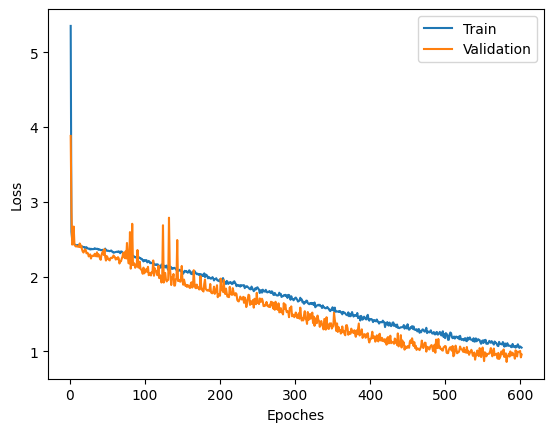

In [13]:
plot_loss(history)


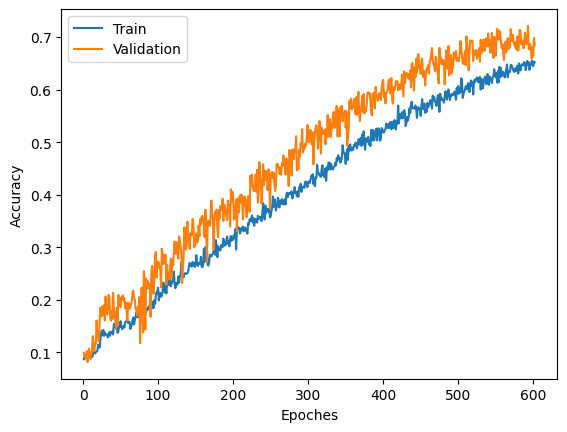

In [14]:
plot_acc(history)


In [15]:
cfg.update({"ending_th": 150})
bestd_model, train_history = train_model(bestd_model, True, cfg, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 001/2000] loss = 1.95203, acc = 0.48603, lr = 0.0003
[Valid | 001/2000][Best | 1] loss = 0.89682[0.89682], acc = 0.70982[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 002/2000] loss = 1.97390, acc = 0.48411, lr = 0.0003
[Valid | 002/2000][Best | 1] loss = 0.91224[0.89682], acc = 0.71181[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 003/2000] loss = 1.93100, acc = 0.48071, lr = 0.0003
[Valid | 003/2000][Best | 3] loss = 0.88983[0.88983], acc = 0.71478[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 004/2000] loss = 1.89524, acc = 0.49792, lr = 0.0003
[Valid | 004/2000][Best | 3] loss = 0.89081[0.88983], acc = 0.72024[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 005/2000] loss = 1.94577, acc = 0.48958, lr = 0.0003
[Valid | 005/2000][Best | 3] loss = 0.89330[0.88983], acc = 0.71280[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 006/2000] loss = 1.94672, acc = 0.49375, lr = 0.0003
[Valid | 006/2000][Best | 3] loss = 0.89277[0.88983], acc = 0.71875[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 007/2000] loss = 1.97977, acc = 0.48328, lr = 0.0003
[Valid | 007/2000][Best | 3] loss = 0.90327[0.88983], acc = 0.71329[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 008/2000] loss = 1.97206, acc = 0.48225, lr = 0.0003
[Valid | 008/2000][Best | 3] loss = 0.90016[0.88983], acc = 0.71677[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 009/2000] loss = 1.94418, acc = 0.49036, lr = 0.0003
[Valid | 009/2000][Best | 3] loss = 0.91094[0.88983], acc = 0.70784[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 010/2000] loss = 1.91767, acc = 0.49740, lr = 0.0003
[Valid | 010/2000][Best | 3] loss = 0.89508[0.88983], acc = 0.71627[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 011/2000] loss = 1.93097, acc = 0.48620, lr = 0.0003
[Valid | 011/2000][Best | 3] loss = 0.89831[0.88983], acc = 0.71429[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 012/2000] loss = 1.96775, acc = 0.48958, lr = 0.0003
[Valid | 012/2000][Best | 3] loss = 0.90252[0.88983], acc = 0.72123[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 013/2000] loss = 1.95495, acc = 0.48663, lr = 0.0003
[Valid | 013/2000][Best | 3] loss = 0.90224[0.88983], acc = 0.71131[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 014/2000] loss = 1.94658, acc = 0.49383, lr = 0.0003
[Valid | 014/2000][Best | 3] loss = 0.89913[0.88983], acc = 0.71528[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 015/2000] loss = 2.00651, acc = 0.47659, lr = 0.0003
[Valid | 015/2000][Best | 3] loss = 0.90741[0.88983], acc = 0.71032[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 016/2000] loss = 1.89131, acc = 0.49766, lr = 0.0003
[Valid | 016/2000][Best | 3] loss = 0.89514[0.88983], acc = 0.71181[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 017/2000] loss = 1.89435, acc = 0.48932, lr = 0.0003
[Valid | 017/2000][Best | 3] loss = 0.91106[0.88983], acc = 0.71379[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 018/2000] loss = 1.95128, acc = 0.48984, lr = 0.0003
[Valid | 018/2000][Best | 3] loss = 0.89644[0.88983], acc = 0.71776[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 019/2000] loss = 1.87435, acc = 0.49710, lr = 0.0003
[Valid | 019/2000][Best | 3] loss = 0.90652[0.88983], acc = 0.70288[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 020/2000] loss = 1.94592, acc = 0.48151, lr = 0.0003
[Valid | 020/2000][Best | 3] loss = 0.90544[0.88983], acc = 0.71726[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 021/2000] loss = 1.93745, acc = 0.49271, lr = 0.0003
[Valid | 021/2000][Best | 3] loss = 0.89710[0.88983], acc = 0.71379[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 022/2000] loss = 1.91240, acc = 0.50501, lr = 0.0003
[Valid | 022/2000][Best | 3] loss = 0.90043[0.88983], acc = 0.71726[0.71478]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 023/2000] loss = 1.93713, acc = 0.48919, lr = 0.0003
[Valid | 023/2000][Best | 23] loss = 0.88431[0.88431], acc = 0.73016[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 024/2000] loss = 1.99594, acc = 0.47994, lr = 0.0003
[Valid | 024/2000][Best | 23] loss = 0.89607[0.88431], acc = 0.71280[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 025/2000] loss = 1.92171, acc = 0.48880, lr = 0.0003
[Valid | 025/2000][Best | 23] loss = 0.90102[0.88431], acc = 0.71726[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 026/2000] loss = 1.93664, acc = 0.49010, lr = 0.0003
[Valid | 026/2000][Best | 23] loss = 0.88421[0.88431], acc = 0.71677[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 027/2000] loss = 1.92395, acc = 0.48750, lr = 0.0003
[Valid | 027/2000][Best | 23] loss = 0.89592[0.88431], acc = 0.71825[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 028/2000] loss = 1.89867, acc = 0.49896, lr = 0.0003
[Valid | 028/2000][Best | 23] loss = 0.89302[0.88431], acc = 0.71577[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 029/2000] loss = 1.96465, acc = 0.48438, lr = 0.0003
[Valid | 029/2000][Best | 23] loss = 0.89714[0.88431], acc = 0.71081[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 030/2000] loss = 1.91172, acc = 0.49408, lr = 0.0003
[Valid | 030/2000][Best | 23] loss = 0.91046[0.88431], acc = 0.71776[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 031/2000] loss = 1.96441, acc = 0.48483, lr = 0.0003
[Valid | 031/2000][Best | 23] loss = 0.89509[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 032/2000] loss = 1.94654, acc = 0.48663, lr = 0.0003
[Valid | 032/2000][Best | 23] loss = 0.89111[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 033/2000] loss = 1.95721, acc = 0.47968, lr = 0.0003
[Valid | 033/2000][Best | 23] loss = 0.89274[0.88431], acc = 0.71627[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 034/2000] loss = 1.98171, acc = 0.48071, lr = 0.0003
[Valid | 034/2000][Best | 23] loss = 0.90609[0.88431], acc = 0.71478[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 035/2000] loss = 1.94270, acc = 0.49740, lr = 0.0003
[Valid | 035/2000][Best | 23] loss = 0.89468[0.88431], acc = 0.72222[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 036/2000] loss = 1.95938, acc = 0.48045, lr = 0.0003
[Valid | 036/2000][Best | 23] loss = 0.89430[0.88431], acc = 0.72272[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 037/2000] loss = 1.93855, acc = 0.49505, lr = 0.0003
[Valid | 037/2000][Best | 23] loss = 0.89759[0.88431], acc = 0.72272[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 038/2000] loss = 1.90392, acc = 0.48655, lr = 0.0003
[Valid | 038/2000][Best | 23] loss = 0.91645[0.88431], acc = 0.71379[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 039/2000] loss = 1.95568, acc = 0.49661, lr = 0.0003
[Valid | 039/2000][Best | 23] loss = 0.89122[0.88431], acc = 0.71478[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 040/2000] loss = 1.96612, acc = 0.49167, lr = 0.0003
[Valid | 040/2000][Best | 23] loss = 0.88229[0.88431], acc = 0.72669[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 041/2000] loss = 1.97272, acc = 0.48200, lr = 0.0003
[Valid | 041/2000][Best | 23] loss = 0.88783[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 042/2000] loss = 1.94499, acc = 0.49219, lr = 0.0003
[Valid | 042/2000][Best | 23] loss = 0.89780[0.88431], acc = 0.71577[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 043/2000] loss = 1.94306, acc = 0.49818, lr = 0.0003
[Valid | 043/2000][Best | 23] loss = 0.88965[0.88431], acc = 0.72173[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 044/2000] loss = 1.92162, acc = 0.50208, lr = 0.0003
[Valid | 044/2000][Best | 23] loss = 0.88894[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 045/2000] loss = 1.94101, acc = 0.48568, lr = 0.0003
[Valid | 045/2000][Best | 23] loss = 0.90695[0.88431], acc = 0.70784[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 046/2000] loss = 1.94112, acc = 0.48576, lr = 0.0003
[Valid | 046/2000][Best | 23] loss = 0.89114[0.88431], acc = 0.72371[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 047/2000] loss = 1.93605, acc = 0.48229, lr = 0.0003
[Valid | 047/2000][Best | 23] loss = 0.90834[0.88431], acc = 0.71429[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 048/2000] loss = 1.95529, acc = 0.48620, lr = 0.0003
[Valid | 048/2000][Best | 23] loss = 0.90024[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 049/2000] loss = 1.90765, acc = 0.50078, lr = 0.0003
[Valid | 049/2000][Best | 23] loss = 0.89532[0.88431], acc = 0.72470[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 050/2000] loss = 1.95155, acc = 0.48984, lr = 0.0003
[Valid | 050/2000][Best | 23] loss = 0.90364[0.88431], acc = 0.71478[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 051/2000] loss = 1.96874, acc = 0.48945, lr = 0.0003
[Valid | 051/2000][Best | 23] loss = 0.89908[0.88431], acc = 0.72321[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 052/2000] loss = 1.93859, acc = 0.48972, lr = 0.0003
[Valid | 052/2000][Best | 23] loss = 0.90538[0.88431], acc = 0.72222[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 053/2000] loss = 1.94700, acc = 0.48560, lr = 0.0003
[Valid | 053/2000][Best | 23] loss = 0.89300[0.88431], acc = 0.70784[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 054/2000] loss = 1.92541, acc = 0.49349, lr = 0.0003
[Valid | 054/2000][Best | 23] loss = 0.91037[0.88431], acc = 0.70933[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 055/2000] loss = 1.92275, acc = 0.48894, lr = 0.0003
[Valid | 055/2000][Best | 23] loss = 0.90500[0.88431], acc = 0.71577[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 056/2000] loss = 1.92561, acc = 0.49126, lr = 0.0003
[Valid | 056/2000][Best | 23] loss = 0.89292[0.88431], acc = 0.71776[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 057/2000] loss = 1.93925, acc = 0.48740, lr = 0.0003
[Valid | 057/2000][Best | 23] loss = 0.89488[0.88431], acc = 0.72321[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 058/2000] loss = 1.93967, acc = 0.49922, lr = 0.0003
[Valid | 058/2000][Best | 23] loss = 0.90503[0.88431], acc = 0.71726[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 059/2000] loss = 1.92756, acc = 0.49499, lr = 0.0003
[Valid | 059/2000][Best | 23] loss = 0.90511[0.88431], acc = 0.71081[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 060/2000] loss = 1.98519, acc = 0.48620, lr = 0.0003
[Valid | 060/2000][Best | 23] loss = 0.90371[0.88431], acc = 0.70833[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 061/2000] loss = 1.93180, acc = 0.49089, lr = 0.0003
[Valid | 061/2000][Best | 23] loss = 0.91788[0.88431], acc = 0.71280[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 062/2000] loss = 1.97427, acc = 0.48698, lr = 0.0003
[Valid | 062/2000][Best | 23] loss = 0.89454[0.88431], acc = 0.72123[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 063/2000] loss = 1.89368, acc = 0.50052, lr = 0.0003
[Valid | 063/2000][Best | 23] loss = 0.89561[0.88431], acc = 0.71776[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 064/2000] loss = 1.93486, acc = 0.48307, lr = 0.0003
[Valid | 064/2000][Best | 23] loss = 0.89809[0.88431], acc = 0.70883[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 065/2000] loss = 1.94148, acc = 0.48672, lr = 0.0003
[Valid | 065/2000][Best | 23] loss = 0.89835[0.88431], acc = 0.71677[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 066/2000] loss = 1.94162, acc = 0.48906, lr = 0.0003
[Valid | 066/2000][Best | 23] loss = 0.88981[0.88431], acc = 0.71478[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 067/2000] loss = 1.88816, acc = 0.49235, lr = 0.0003
[Valid | 067/2000][Best | 23] loss = 0.89212[0.88431], acc = 0.71528[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 068/2000] loss = 1.91585, acc = 0.49794, lr = 0.0003
[Valid | 068/2000][Best | 23] loss = 0.89674[0.88431], acc = 0.72073[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 069/2000] loss = 1.97582, acc = 0.49254, lr = 0.0003
[Valid | 069/2000][Best | 23] loss = 0.88962[0.88431], acc = 0.72272[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 070/2000] loss = 1.96929, acc = 0.48097, lr = 0.0003
[Valid | 070/2000][Best | 23] loss = 0.89750[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 071/2000] loss = 1.90871, acc = 0.48708, lr = 0.0003
[Valid | 071/2000][Best | 23] loss = 0.88866[0.88431], acc = 0.71627[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 072/2000] loss = 1.91666, acc = 0.49453, lr = 0.0003
[Valid | 072/2000][Best | 23] loss = 0.89975[0.88431], acc = 0.70635[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 073/2000] loss = 1.90574, acc = 0.50026, lr = 0.0003
[Valid | 073/2000][Best | 23] loss = 0.89048[0.88431], acc = 0.71627[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 074/2000] loss = 1.93276, acc = 0.48750, lr = 0.0003
[Valid | 074/2000][Best | 23] loss = 0.89989[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 075/2000] loss = 1.94261, acc = 0.49203, lr = 0.0003
[Valid | 075/2000][Best | 23] loss = 0.89497[0.88431], acc = 0.71677[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 076/2000] loss = 1.93864, acc = 0.48894, lr = 0.0003
[Valid | 076/2000][Best | 23] loss = 0.90126[0.88431], acc = 0.70685[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 077/2000] loss = 1.92065, acc = 0.48843, lr = 0.0003
[Valid | 077/2000][Best | 23] loss = 0.90221[0.88431], acc = 0.72321[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 078/2000] loss = 1.94563, acc = 0.48984, lr = 0.0003
[Valid | 078/2000][Best | 23] loss = 0.89692[0.88431], acc = 0.71825[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 079/2000] loss = 1.90990, acc = 0.50599, lr = 0.0003
[Valid | 079/2000][Best | 23] loss = 0.89977[0.88431], acc = 0.71825[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 080/2000] loss = 1.96012, acc = 0.48637, lr = 0.0003
[Valid | 080/2000][Best | 23] loss = 0.90384[0.88431], acc = 0.71081[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 081/2000] loss = 1.91873, acc = 0.50104, lr = 0.0003
[Valid | 081/2000][Best | 23] loss = 0.90962[0.88431], acc = 0.71825[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 082/2000] loss = 1.91953, acc = 0.49177, lr = 0.0003
[Valid | 082/2000][Best | 23] loss = 0.90143[0.88431], acc = 0.70833[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 083/2000] loss = 1.91706, acc = 0.49100, lr = 0.0003
[Valid | 083/2000][Best | 23] loss = 0.89746[0.88431], acc = 0.70982[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 084/2000] loss = 1.95628, acc = 0.47917, lr = 0.0003
[Valid | 084/2000][Best | 23] loss = 0.89821[0.88431], acc = 0.71131[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 085/2000] loss = 1.97665, acc = 0.49280, lr = 0.0003
[Valid | 085/2000][Best | 23] loss = 0.90233[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 086/2000] loss = 1.90828, acc = 0.49792, lr = 0.0003
[Valid | 086/2000][Best | 23] loss = 0.89260[0.88431], acc = 0.71825[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 087/2000] loss = 1.89059, acc = 0.50106, lr = 0.0003
[Valid | 087/2000][Best | 23] loss = 0.90728[0.88431], acc = 0.70982[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 088/2000] loss = 1.93442, acc = 0.49588, lr = 0.0003
[Valid | 088/2000][Best | 23] loss = 0.88622[0.88431], acc = 0.71925[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 089/2000] loss = 1.95859, acc = 0.49505, lr = 0.0003
[Valid | 089/2000][Best | 23] loss = 0.89534[0.88431], acc = 0.71726[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 090/2000] loss = 1.94237, acc = 0.49367, lr = 0.0003
[Valid | 090/2000][Best | 23] loss = 0.89861[0.88431], acc = 0.71726[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 091/2000] loss = 1.92381, acc = 0.49063, lr = 0.0003
[Valid | 091/2000][Best | 23] loss = 0.87965[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 092/2000] loss = 2.00679, acc = 0.47993, lr = 0.0003
[Valid | 092/2000][Best | 23] loss = 0.89515[0.88431], acc = 0.72173[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 093/2000] loss = 1.94677, acc = 0.48663, lr = 0.0003
[Valid | 093/2000][Best | 23] loss = 0.89445[0.88431], acc = 0.71726[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 094/2000] loss = 1.96225, acc = 0.48490, lr = 0.0003
[Valid | 094/2000][Best | 23] loss = 0.89108[0.88431], acc = 0.72073[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 095/2000] loss = 1.91495, acc = 0.49089, lr = 0.0003
[Valid | 095/2000][Best | 23] loss = 0.89890[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 096/2000] loss = 1.94755, acc = 0.48431, lr = 0.0003
[Valid | 096/2000][Best | 23] loss = 0.91577[0.88431], acc = 0.71230[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 097/2000] loss = 1.94448, acc = 0.48464, lr = 0.0003
[Valid | 097/2000][Best | 23] loss = 0.89751[0.88431], acc = 0.71478[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 098/2000] loss = 1.90308, acc = 0.49323, lr = 0.0003
[Valid | 098/2000][Best | 23] loss = 0.88985[0.88431], acc = 0.72669[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 099/2000] loss = 1.89244, acc = 0.50079, lr = 0.0003
[Valid | 099/2000][Best | 23] loss = 0.89564[0.88431], acc = 0.72073[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 100/2000] loss = 1.93102, acc = 0.48603, lr = 0.0003
[Valid | 100/2000][Best | 23] loss = 0.89240[0.88431], acc = 0.71776[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 101/2000] loss = 1.94956, acc = 0.48490, lr = 0.0003
[Valid | 101/2000][Best | 23] loss = 0.90266[0.88431], acc = 0.71677[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 102/2000] loss = 1.95115, acc = 0.48125, lr = 0.0003
[Valid | 102/2000][Best | 23] loss = 0.90556[0.88431], acc = 0.70635[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 103/2000] loss = 1.91989, acc = 0.49842, lr = 0.0003
[Valid | 103/2000][Best | 23] loss = 0.89820[0.88431], acc = 0.71528[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 104/2000] loss = 1.97896, acc = 0.47785, lr = 0.0003
[Valid | 104/2000][Best | 23] loss = 0.90767[0.88431], acc = 0.70635[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 105/2000] loss = 1.92428, acc = 0.49479, lr = 0.0003
[Valid | 105/2000][Best | 23] loss = 0.90673[0.88431], acc = 0.71379[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 106/2000] loss = 1.96140, acc = 0.47474, lr = 0.0003
[Valid | 106/2000][Best | 23] loss = 0.89857[0.88431], acc = 0.72222[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 107/2000] loss = 1.87281, acc = 0.49156, lr = 0.0003
[Valid | 107/2000][Best | 23] loss = 0.89766[0.88431], acc = 0.71627[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 108/2000] loss = 1.94478, acc = 0.48787, lr = 0.0003
[Valid | 108/2000][Best | 23] loss = 0.89919[0.88431], acc = 0.71577[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 109/2000] loss = 1.89414, acc = 0.49921, lr = 0.0003
[Valid | 109/2000][Best | 23] loss = 0.89516[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 110/2000] loss = 1.89512, acc = 0.49815, lr = 0.0003
[Valid | 110/2000][Best | 23] loss = 0.88662[0.88431], acc = 0.72222[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 111/2000] loss = 1.91826, acc = 0.49167, lr = 0.0003
[Valid | 111/2000][Best | 23] loss = 0.90544[0.88431], acc = 0.71230[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 112/2000] loss = 1.93414, acc = 0.49427, lr = 0.0003
[Valid | 112/2000][Best | 23] loss = 0.88546[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 113/2000] loss = 1.92683, acc = 0.49089, lr = 0.0003
[Valid | 113/2000][Best | 23] loss = 0.89140[0.88431], acc = 0.71478[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 114/2000] loss = 1.94906, acc = 0.49193, lr = 0.0003
[Valid | 114/2000][Best | 23] loss = 0.88586[0.88431], acc = 0.72073[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 115/2000] loss = 1.91043, acc = 0.49126, lr = 0.0003
[Valid | 115/2000][Best | 23] loss = 0.91370[0.88431], acc = 0.71181[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 116/2000] loss = 1.91159, acc = 0.50105, lr = 0.0003
[Valid | 116/2000][Best | 23] loss = 0.88817[0.88431], acc = 0.71825[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 117/2000] loss = 1.89160, acc = 0.49657, lr = 0.0003
[Valid | 117/2000][Best | 23] loss = 0.89096[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 118/2000] loss = 1.93909, acc = 0.49156, lr = 0.0003
[Valid | 118/2000][Best | 23] loss = 0.89249[0.88431], acc = 0.71528[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 119/2000] loss = 1.89150, acc = 0.49156, lr = 0.0003
[Valid | 119/2000][Best | 23] loss = 0.91263[0.88431], acc = 0.71528[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 120/2000] loss = 1.95494, acc = 0.48740, lr = 0.0003
[Valid | 120/2000][Best | 23] loss = 0.90455[0.88431], acc = 0.70734[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 121/2000] loss = 1.95193, acc = 0.48724, lr = 0.0003
[Valid | 121/2000][Best | 23] loss = 0.90112[0.88431], acc = 0.72569[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 122/2000] loss = 1.94353, acc = 0.49089, lr = 0.0003
[Valid | 122/2000][Best | 23] loss = 0.89342[0.88431], acc = 0.71627[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 123/2000] loss = 1.94856, acc = 0.47891, lr = 0.0003
[Valid | 123/2000][Best | 23] loss = 0.89039[0.88431], acc = 0.71677[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 124/2000] loss = 1.95785, acc = 0.48122, lr = 0.0003
[Valid | 124/2000][Best | 23] loss = 0.90658[0.88431], acc = 0.71677[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 125/2000] loss = 1.91932, acc = 0.50000, lr = 0.0003
[Valid | 125/2000][Best | 23] loss = 0.90887[0.88431], acc = 0.71726[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 126/2000] loss = 1.91211, acc = 0.50260, lr = 0.0003
[Valid | 126/2000][Best | 23] loss = 0.89890[0.88431], acc = 0.70933[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 127/2000] loss = 1.99705, acc = 0.47479, lr = 0.0003
[Valid | 127/2000][Best | 23] loss = 0.90735[0.88431], acc = 0.71230[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 128/2000] loss = 1.92362, acc = 0.49661, lr = 0.0003
[Valid | 128/2000][Best | 23] loss = 0.89880[0.88431], acc = 0.72123[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 129/2000] loss = 1.95265, acc = 0.49228, lr = 0.0003
[Valid | 129/2000][Best | 23] loss = 0.89555[0.88431], acc = 0.71528[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 130/2000] loss = 1.89422, acc = 0.49280, lr = 0.0003
[Valid | 130/2000][Best | 23] loss = 0.89790[0.88431], acc = 0.70784[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 131/2000] loss = 1.95745, acc = 0.48611, lr = 0.0003
[Valid | 131/2000][Best | 23] loss = 0.90521[0.88431], acc = 0.71627[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 132/2000] loss = 1.95610, acc = 0.48464, lr = 0.0003
[Valid | 132/2000][Best | 23] loss = 0.90019[0.88431], acc = 0.71230[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 133/2000] loss = 1.95177, acc = 0.47656, lr = 0.0003
[Valid | 133/2000][Best | 23] loss = 0.88984[0.88431], acc = 0.71875[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 134/2000] loss = 1.89562, acc = 0.50755, lr = 0.0003
[Valid | 134/2000][Best | 23] loss = 0.90040[0.88431], acc = 0.71627[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 135/2000] loss = 1.90601, acc = 0.49103, lr = 0.0003
[Valid | 135/2000][Best | 23] loss = 0.89171[0.88431], acc = 0.70635[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 136/2000] loss = 1.99788, acc = 0.48374, lr = 0.0003
[Valid | 136/2000][Best | 23] loss = 0.89172[0.88431], acc = 0.72173[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 137/2000] loss = 1.98092, acc = 0.48516, lr = 0.0003
[Valid | 137/2000][Best | 23] loss = 0.89956[0.88431], acc = 0.71577[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 138/2000] loss = 1.95943, acc = 0.49182, lr = 0.0003
[Valid | 138/2000][Best | 23] loss = 0.88968[0.88431], acc = 0.72173[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 139/2000] loss = 1.87673, acc = 0.49842, lr = 0.0003
[Valid | 139/2000][Best | 23] loss = 0.88552[0.88431], acc = 0.71825[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 140/2000] loss = 1.91583, acc = 0.49427, lr = 0.0003
[Valid | 140/2000][Best | 23] loss = 0.90828[0.88431], acc = 0.72569[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 141/2000] loss = 1.97123, acc = 0.48672, lr = 0.0003
[Valid | 141/2000][Best | 23] loss = 0.89783[0.88431], acc = 0.71181[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 142/2000] loss = 1.95501, acc = 0.48663, lr = 0.0003
[Valid | 142/2000][Best | 23] loss = 0.90987[0.88431], acc = 0.70784[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 143/2000] loss = 1.90789, acc = 0.48411, lr = 0.0003
[Valid | 143/2000][Best | 23] loss = 0.90035[0.88431], acc = 0.71528[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 144/2000] loss = 1.93215, acc = 0.49974, lr = 0.0003
[Valid | 144/2000][Best | 23] loss = 0.91501[0.88431], acc = 0.71280[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 145/2000] loss = 1.96745, acc = 0.48229, lr = 0.0003
[Valid | 145/2000][Best | 23] loss = 0.89957[0.88431], acc = 0.71825[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 146/2000] loss = 1.93502, acc = 0.48688, lr = 0.0003
[Valid | 146/2000][Best | 23] loss = 0.90644[0.88431], acc = 0.71429[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00047: reducing learning rate of group 0 to 1.5000e-04.
[Train | 147/2000] loss = 1.90510, acc = 0.49420, lr = 0.00015
[Valid | 147/2000][Best | 23] loss = 0.89792[0.88431], acc = 0.71131[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 148/2000] loss = 1.93124, acc = 0.48663, lr = 0.00015
[Valid | 148/2000][Best | 23] loss = 0.89358[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 149/2000] loss = 1.94867, acc = 0.48385, lr = 0.00015
[Valid | 149/2000][Best | 23] loss = 0.90790[0.88431], acc = 0.71329[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 150/2000] loss = 1.94648, acc = 0.48932, lr = 0.00015
[Valid | 150/2000][Best | 23] loss = 0.89211[0.88431], acc = 0.71925[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 151/2000] loss = 1.91099, acc = 0.48880, lr = 0.00015
[Valid | 151/2000][Best | 23] loss = 0.90416[0.88431], acc = 0.71131[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 152/2000] loss = 1.90765, acc = 0.49479, lr = 0.00015
[Valid | 152/2000][Best | 23] loss = 0.89285[0.88431], acc = 0.72123[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 153/2000] loss = 1.95400, acc = 0.48411, lr = 0.00015
[Valid | 153/2000][Best | 23] loss = 0.90651[0.88431], acc = 0.70685[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 154/2000] loss = 1.88352, acc = 0.49868, lr = 0.00015
[Valid | 154/2000][Best | 23] loss = 0.89619[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 155/2000] loss = 1.97187, acc = 0.48594, lr = 0.00015
[Valid | 155/2000][Best | 23] loss = 0.89603[0.88431], acc = 0.72024[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 156/2000] loss = 1.85182, acc = 0.51002, lr = 0.00015
[Valid | 156/2000][Best | 23] loss = 0.89848[0.88431], acc = 0.71726[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 157/2000] loss = 1.90117, acc = 0.49948, lr = 0.00015
[Valid | 157/2000][Best | 23] loss = 0.89145[0.88431], acc = 0.72222[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 158/2000] loss = 1.95136, acc = 0.48464, lr = 0.00015
[Valid | 158/2000][Best | 23] loss = 0.89207[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 159/2000] loss = 1.89490, acc = 0.49818, lr = 0.00015
[Valid | 159/2000][Best | 23] loss = 0.90156[0.88431], acc = 0.71181[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 160/2000] loss = 1.93148, acc = 0.49766, lr = 0.00015
[Valid | 160/2000][Best | 23] loss = 0.89964[0.88431], acc = 0.71577[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 161/2000] loss = 1.88802, acc = 0.49427, lr = 0.00015
[Valid | 161/2000][Best | 23] loss = 0.89642[0.88431], acc = 0.71379[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 162/2000] loss = 1.94751, acc = 0.48817, lr = 0.00015
[Valid | 162/2000][Best | 23] loss = 0.90521[0.88431], acc = 0.70734[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 163/2000] loss = 1.89683, acc = 0.49349, lr = 0.00015
[Valid | 163/2000][Best | 23] loss = 0.90553[0.88431], acc = 0.70833[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 164/2000] loss = 1.93849, acc = 0.49048, lr = 0.00015
[Valid | 164/2000][Best | 23] loss = 0.89193[0.88431], acc = 0.71677[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 165/2000] loss = 1.92391, acc = 0.49089, lr = 0.00015
[Valid | 165/2000][Best | 23] loss = 0.89871[0.88431], acc = 0.70883[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 166/2000] loss = 1.96394, acc = 0.48333, lr = 0.00015
[Valid | 166/2000][Best | 23] loss = 0.90409[0.88431], acc = 0.71181[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 167/2000] loss = 1.93950, acc = 0.49635, lr = 0.00015
[Valid | 167/2000][Best | 23] loss = 0.89185[0.88431], acc = 0.72371[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 168/2000] loss = 1.92001, acc = 0.48672, lr = 0.00015
[Valid | 168/2000][Best | 23] loss = 0.90241[0.88431], acc = 0.71627[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 169/2000] loss = 1.94275, acc = 0.49375, lr = 0.00015
[Valid | 169/2000][Best | 23] loss = 0.90156[0.88431], acc = 0.71131[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 170/2000] loss = 1.91802, acc = 0.48945, lr = 0.00015
[Valid | 170/2000][Best | 23] loss = 0.90668[0.88431], acc = 0.70288[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 171/2000] loss = 1.88377, acc = 0.50052, lr = 0.00015
[Valid | 171/2000][Best | 23] loss = 0.89796[0.88431], acc = 0.71528[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 172/2000] loss = 1.94971, acc = 0.48698, lr = 0.00015
[Valid | 172/2000][Best | 23] loss = 0.89379[0.88431], acc = 0.71974[0.73016]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00073: reducing learning rate of group 0 to 7.5000e-05.
[Train | 173/2000] loss = 1.90933, acc = 0.48681, lr = 7.5e-05
[Valid | 173/2000][Best | 23] loss = 0.88822[0.88431], acc = 0.72421[0.73016]


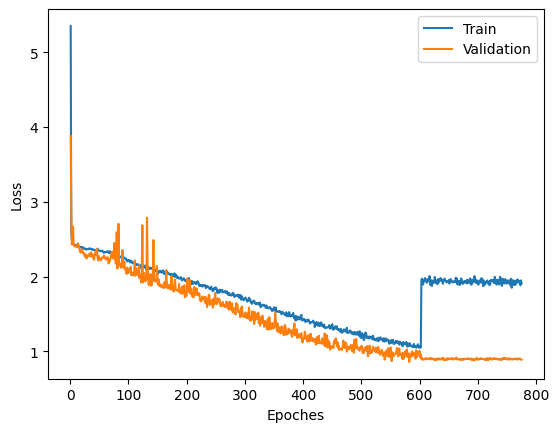

In [16]:
plot_loss(history)


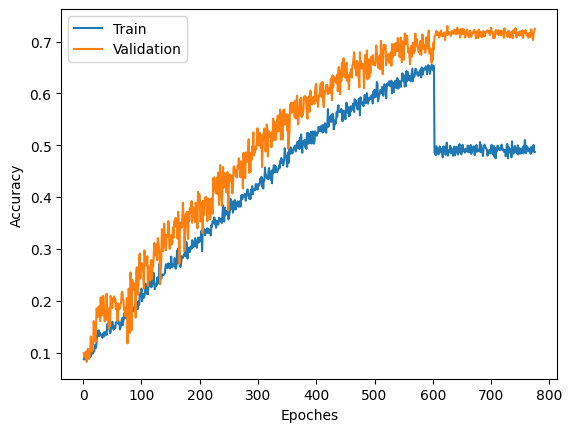

In [17]:
plot_acc(history)


## Testing


In [18]:
# model_path = "model/modelName/savedName.pth"
# bestd_model.load_state_dict(torch.load(model_path, map_location=device))


In [19]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestd_model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestd_model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [20]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
